In [4]:
import matplotlib.pyplot as plt
import seaborn as sns



In [1]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('OneDrive_1_2025-6-11/data/plcgtfs-20240101.csv', skiprows=1)

# Translate column names
translations = {
    'Tag': 'Date',
    'Kurzbezeichnung': 'ShortName',
    'ZugNr': 'TrainNumber',
    'FahrtNr': 'TripNumber',
    'FahrtArt': 'TripType',
    'FahrtStartSekunden': 'TripStartSeconds',
    'FahrtEndeSekunden': 'TripEndSeconds',
    'FahrtStart': 'TripStart',
    'FahrtEnde': 'TripEnd',
    'LinienNr': 'LineNumber',
    'LinienRichtungText': 'LineDirection',
    'AnkunftSekunden': 'ArrivalSeconds',
    'AbfahrtSekunden': 'DepartureSeconds',
    'Ein1Klasse': 'Board1stClass',
    'Aus1Klasse': 'Alight1stClass',
    'Belegung1Klasse': 'Occupancy1stClass',
    'Ein2Klasse': 'Board2ndClass',
    'Aus2Klasse': 'Alight2ndClass',
    'Belegung2Klasse': 'Occupancy2ndClass',
    'DistanzMeter': 'DistanceMeters',
    'Kurzbezeichnung1': 'StationCode',
    'DidokNr': 'StationID'
}
df.rename(columns=translations, inplace=True)

print("=== Basic Data Information ===")
print(f"Total Rows: {len(df):,}")
print(f"Number of Lines: {df['LineNumber'].nunique()}")
print(f"Number of Trips: {df['TripNumber'].nunique()}")
print(f"Number of Stations: {df['StationID'].nunique()}")

# Data cleaning and preparation
print("\n=== Data Cleaning ===")
df_clean = df.dropna(subset=['ArrivalSeconds', 'DepartureSeconds'])
print(f"Rows after cleaning: {len(df_clean):,}")

# Fix time format (European format: day.month.year)
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%d.%m.%Y %H:%M:%S')
df_clean['TripStart'] = pd.to_datetime(df_clean['TripStart'], format='%d/%m/%Y %H:%M:%S')
df_clean['TripEnd'] = pd.to_datetime(df_clean['TripEnd'], format='%d/%m/%Y %H:%M:%S')
print(f"Date Range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")

# Calculate delay time
df_clean['DelaySeconds'] = df_clean['ArrivalSeconds'] - df_clean['TripStartSeconds']

print("\n=== On-Time Performance Analysis ===")
# On-time threshold (±2 minutes)
on_time_threshold = 120
df_clean['OnTime'] = (abs(df_clean['DelaySeconds']) <= on_time_threshold)

# Overall on-time rate
overall_on_time = df_clean['OnTime'].mean() * 100
print(f"Overall On-Time Rate: {overall_on_time:.1f}%")

# Delay statistics
print(f"Average Delay: {df_clean['DelaySeconds'].mean():.1f} seconds")
print(f"Median Delay: {df_clean['DelaySeconds'].median():.1f} seconds")

print("\n=== On-Time Rate by Line ===")
line_stats = df_clean.groupby('LineNumber').agg({
    'OnTime': 'mean',
    'DelaySeconds': 'mean',
    'TripNumber': 'count'
}).round(3)
line_stats['On-Time Rate %'] = line_stats['OnTime'] * 100
line_stats = line_stats.rename(columns={'TripNumber': 'Records', 'DelaySeconds': 'AvgDelaySeconds'})

print("Top 5 Lines by On-Time Rate:")
print(line_stats.sort_values('On-Time Rate %', ascending=False).head())
print("\nBottom 5 Lines by On-Time Rate:")
print(line_stats.sort_values('On-Time Rate %', ascending=True).head())

print("\n=== Time of Day Analysis ===")
df_clean['Hour'] = df_clean['TripStart'].dt.hour
hourly_stats = df_clean.groupby('Hour')['OnTime'].mean() * 100
print("On-Time Rate by Hour:")
for hour, rate in hourly_stats.items():
    print(f"{hour:2d}h: {rate:.1f}%")

print("\n=== Passenger Flow Analysis ===")
df_clean['TotalBoarding'] = df_clean['Board1stClass'] + df_clean['Board2ndClass']
df_clean['TotalOccupancy'] = df_clean['Occupancy1stClass'] + df_clean['Occupancy2ndClass']
print(f"Average Boarding Count: {df_clean['TotalBoarding'].mean():.1f}")
print(f"Average Occupancy: {df_clean['TotalOccupancy'].mean():.1f}")

# On-time rate by occupancy level
high_occupancy = df_clean['TotalOccupancy'] > df_clean['TotalOccupancy'].median()
print(f"High Occupancy Trips On-Time Rate: {df_clean[high_occupancy]['OnTime'].mean()*100:.1f}%")
print(f"Low Occupancy Trips On-Time Rate: {df_clean[~high_occupancy]['OnTime'].mean()*100:.1f}%")

# ==================== New: High Delay Rate Analysis ====================

print("\n" + "="*50)
print("=== High Delay Rate Lines Analysis ===")
print("="*50)

# Filter lines with sufficient data (at least 100 records)
min_records = 100
sufficient_data_lines = line_stats[line_stats['Records'] >= min_records]

# Lines with highest delay rates (lowest on-time rates)
high_delay_lines = sufficient_data_lines.sort_values('On-Time Rate %', ascending=True)

print(f"\nTop 10 Lines with Highest Delay Rate (records ≥ {min_records}):")
print("-" * 60)
print(f"{'Line':<8} {'On-Time %':<10} {'Avg Delay (s)':<15} {'Records':<10}")
print("-" * 60)

for idx, (line_num, row) in enumerate(high_delay_lines.head(10).iterrows()):
    delay_rate = 100 - row['On-Time Rate %']
    print(f"{line_num:<8} {row['On-Time Rate %']:<10.1f} {row['AvgDelaySeconds']:<15.1f} {row['Records']:<10.0f}")

# Severely delayed lines (on-time rate < 70%)
severely_delayed_lines = sufficient_data_lines[sufficient_data_lines['On-Time Rate %'] < 70]
if len(severely_delayed_lines) > 0:
    print(f"\nSeverely Delayed Lines (On-Time Rate < 70%):")
    print(f"Total: {len(severely_delayed_lines)} lines")
    for line_num, row in severely_delayed_lines.iterrows():
        print(f"Line {line_num}: On-Time Rate {row['On-Time Rate %']:.1f}%, Avg Delay {row['AvgDelaySeconds']:.0f}s")

print("\n" + "="*50)
print("=== High Delay Rate Stations Analysis ===")
print("="*50)

# Station-level delay analysis
station_stats = df_clean.groupby(['StationID', 'StationCode']).agg({
    'OnTime': 'mean',
    'DelaySeconds': 'mean',
    'TripNumber': 'count'
}).round(3)

station_stats['On-Time Rate %'] = station_stats['OnTime'] * 100
station_stats = station_stats.rename(columns={'TripNumber': 'Records', 'DelaySeconds': 'AvgDelaySeconds'})

# Filter stations with at least 50 records
min_station_records = 50
sufficient_data_stations = station_stats[station_stats['Records'] >= min_station_records]

# Stations with the highest delay rates
high_delay_stations = sufficient_data_stations.sort_values('On-Time Rate %', ascending=True)

print(f"\nTop 15 Stations with Highest Delay Rates (records ≥ {min_station_records}):")
print("-" * 80)
print(f"{'Station Code':<12} {'Station ID':<12} {'On-Time %':<10} {'Avg Delay (s)':<15} {'Records':<10}")
print("-" * 80)

for idx, ((station_id, station_code), row) in enumerate(high_delay_stations.head(15).iterrows()):
    print(f"{station_code:<12} {station_id:<12} {row['On-Time Rate %']:<10.1f} {row['AvgDelaySeconds']:<15.1f} {row['Records']:<10.0f}")

# Severely delayed stations (on-time rate < 60%)
severely_delayed_stations = sufficient_data_stations[sufficient_data_stations['On-Time Rate %'] < 60]
if len(severely_delayed_stations) > 0:
    print(f"\nSeverely Delayed Stations (On-Time Rate < 60%):")
    print(f"Total: {len(severely_delayed_stations)} stations")
    for (station_id, station_code), row in severely_delayed_stations.iterrows():
        print(f"Station {station_code} (ID: {station_id}): On-Time Rate {row['On-Time Rate %']:.1f}%, Avg Delay {row['AvgDelaySeconds']:.0f}s")

print("\n" + "="*50)
print("=== Line-Station Delay Combination Analysis ===")
print("="*50)

# Line-station delay analysis
line_station_stats = df_clean.groupby(['LineNumber', 'StationCode']).agg({
    'OnTime': 'mean',
    'DelaySeconds': 'mean',
    'TripNumber': 'count'
}).round(3)

line_station_stats['On-Time Rate %'] = line_station_stats['OnTime'] * 100
line_station_stats = line_station_stats.rename(columns={'TripNumber': 'Records', 'DelaySeconds': 'AvgDelaySeconds'})

# Filter combinations with at least 20 records
min_combo_records = 20
sufficient_combo_data = line_station_stats[line_station_stats['Records'] >= min_combo_records]

# Worst delay combinations
worst_combos = sufficient_combo_data.sort_values('On-Time Rate %', ascending=True)

print(f"\nWorst Line-Station Delay Combinations (records ≥ {min_combo_records}):")
print("-" * 75)
print(f"{'Line':<10} {'Station Code':<15} {'On-Time %':<10} {'Avg Delay (s)':<15} {'Records':<10}")
print("-" * 75)

for idx, ((line_num, station_code), row) in enumerate(worst_combos.head(20).iterrows()):
    print(f"{line_num:<10} {station_code:<15} {row['On-Time Rate %']:<10.1f} {row['AvgDelaySeconds']:<15.1f} {row['Records']:<10.0f}")

print("\n" + "="*50)
print("=== Delay Pattern Analysis ===")
print("="*50)

# Define delay categories
def categorize_delay(delay_seconds):
    if delay_seconds <= -120:
        return 'Severely Early'
    elif delay_seconds <= -60:
        return 'Slightly Early'
    elif delay_seconds <= 120:
        return 'On Time'
    elif delay_seconds <= 300:
        return 'Slight Delay'
    elif delay_seconds <= 600:
        return 'Moderate Delay'
    else:
        return 'Severe Delay'

df_clean['DelayCategory'] = df_clean['DelaySeconds'].apply(categorize_delay)

# Delay category distribution
delay_distribution = df_clean['DelayCategory'].value_counts()
delay_percentage = df_clean['DelayCategory'].value_counts(normalize=True) * 100

print("Delay Category Distribution:")
print("-" * 30)
for category in ['Severely Early', 'Slightly Early', 'On Time', 'Slight Delay', 'Moderate Delay', 'Severe Delay']:
    if category in delay_distribution:
        count = delay_distribution[category]
        pct = delay_percentage[category]
        print(f"{category:<16}: {count:>8,} trips ({pct:>5.1f}%)")

# Export recommendation
print(f"\n=== Data Export Recommendation ===")
print("Suggested exports for detailed analysis:")
print("1. high_delay_lines - Lines with highest delay rate")
print("2. high_delay_stations - Stations with highest delay rate")
print("3. worst_combos - Worst line-station delay combinations")

# Optional: export to CSV (uncomment to enable)
# high_delay_lines.to_csv('high_delay_lines.csv', encoding='utf-8-sig')
# high_delay_stations.to_csv('high_delay_stations.csv', encoding='utf-8-sig')
# worst_combos.head(50).to_csv('worst_line_station_combos.csv', encoding='utf-8-sig')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
=== Basic Data Information ===
Total Rows: 1,986,661
Number of Lines: 99
Number of Trips: 8457
Number of Stations: 952

=== Data Cleaning ===
Rows after cleaning: 1,681,331


/var/folders/58/tx0yktsx2rn9t9y3z4q7lcmc0000gn/T/ipykernel_9976/176277573.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%d.%m.%Y %H:%M:%S')
/var/folders/58/tx0yktsx2rn9t9y3z4q7lcmc0000gn/T/ipykernel_9976/176277573.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['TripStart'] = pd.to_datetime(df_clean['TripStart'], format='%d/%m/%Y %H:%M:%S')
/var/folders/58/tx0yktsx2rn9t9y3z4q7lcmc0000gn/T/ipykernel_9976/176277573.py:48: Setting

Date Range: 2024-01-01 00:00:00 to 2024-01-31 00:00:00

=== On-Time Performance Analysis ===
Overall On-Time Rate: 11.3%
Average Delay: 847.6 seconds
Median Delay: 720.0 seconds

=== On-Time Rate by Line ===
Top 5 Lines by On-Time Rate:
            OnTime  AvgDelaySeconds  Records  On-Time Rate %
LineNumber                                                  
13           0.750          119.500     1944            75.0
479          0.501          149.596     7805            50.1
235          0.500          222.112     1158            50.0
130          0.339          243.559     4581            33.9
3            0.330          361.207    52303            33.0

Bottom 5 Lines by On-Time Rate:
            OnTime  AvgDelaySeconds  Records  On-Time Rate %
LineNumber                                                  
9091           0.0         1095.943      315             0.0
475            0.0          576.986      292             0.0
66             0.0         9515.875       96             0.

/var/folders/58/tx0yktsx2rn9t9y3z4q7lcmc0000gn/T/ipykernel_9976/176277573.py:214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['DelayCategory'] = df_clean['DelaySeconds'].apply(categorize_delay)


In [17]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df

,Date,ShortName,TrainNumber,TripNumber,TripType,TripStartSeconds,TripEndSeconds,TripStart,TripEnd,LineNumber,LineDirection,ArrivalSeconds,DepartureSeconds,Board1stClass,Alight1stClass,Occupancy1stClass,Board2ndClass,Alight2ndClass,Occupancy2ndClass,DistanceMeters,Quality,StationCode,StationID
0,01.01.2024 00:00:00,dim,9999006,9999006,2,16620,16980,01/01/2024 04:37:00,01/01/2024 04:43:00,1,Hin,NaN,16620.0,0.0,0.0,0.0,0.0,0.0,0.0,2248,0,DEPgiv,9999800
1,01.01.2024 00:00:00,dim,9999006,9999006,2,16620,16980,01/01/2024 04:37:00,01/01/2024 04:43:00,1,Hin,16980.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0,MCar,8587238
2,01.01.2024 00:00:00,dim,61007,61007,1,16981,17460,01/01/2024 04:43:01,01/01/2024 04:51:00,1,Hin,NaN,16981.0,0.0,0.0,0.0,0.0,0.0,0.0,212,1,MCar,8587238
3,01.01.2024 00:00:00,dim,61007,61007,1,16981,17460,01/01/2024 04:43:01,01/01/2024 04:51:00,1,Hin,17010.0,17010.0,0.0,0.0,0.0,0.0,0.0,0.0,197,1,JURcha,8592379
4,01.01.2024 00:00:00,dim,61007,61007,1,16981,17460,01/01/2024 04:43:01,01/01/2024 04:51:00,1,Hin,17040.0,17040.0,0.0,0.0,0.0,0.0,0.0,0.0,168,1,Fleu,8592370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986656,05.01.2024 00:00:00,lu-ve-vac,87337,87337,1,69180,71640,05/01/2024 19:13:00,05/01/2024 19:54:00,9091,Zur?ck,71640.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,2,SCBgar,8511056
1986657,05.01.2024 00:00:00,lu-ve-vac,9999001,9999001,3,70201,71400,05/01/2024 19:30:01,05/01/2024 19:50:00,9091,Hin,NaN,70201.0,0.0,0.0,0.0,0.0,0.0,0.0,15000,0,MBEpos,8511026
1986658,05.01.2024 00:00:00,lu-ve-vac,9999001,9999001,3,70201,71400,05/01/2024 19:30:01,05/01/2024 19:50:00,9091,Hin,71400.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0,DEPtra,8500729
1986659,05.01.2024 00:00:00,lu-ve-vac,9999016,9999016,3,71641,72480,05/01/2024 19:54:01,05/01/2024 20:08:00,9091,Hin,NaN,71641.0,0.0,0.0,0.0,0.0,0.0,0.0,11600,0,SCBgar,8511056


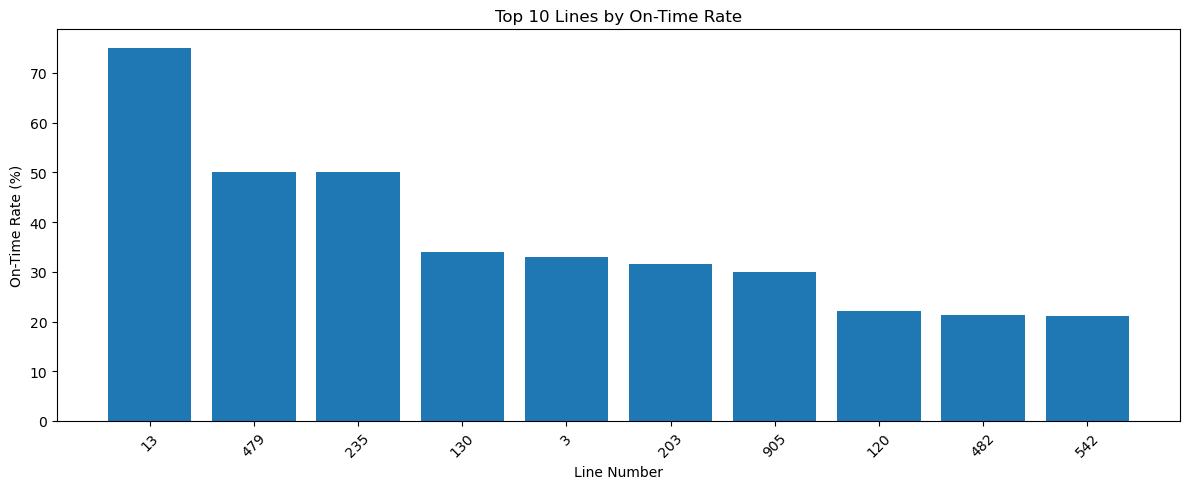

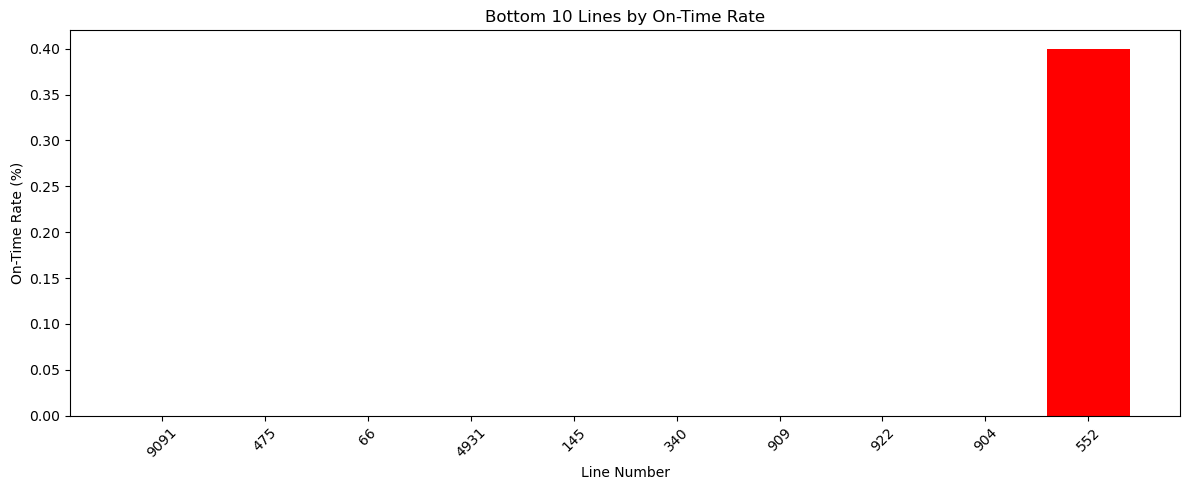

In [5]:
# Top 10 Lines by On-Time Rate
top_lines = line_stats.sort_values('On-Time Rate %', ascending=False).head(10)
bottom_lines = line_stats.sort_values('On-Time Rate %', ascending=True).head(10)

plt.figure(figsize=(12, 5))
plt.bar(top_lines.index.astype(str), top_lines['On-Time Rate %'])
plt.title("Top 10 Lines by On-Time Rate")
plt.xlabel("Line Number")
plt.ylabel("On-Time Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(bottom_lines.index.astype(str), bottom_lines['On-Time Rate %'], color='red')
plt.title("Bottom 10 Lines by On-Time Rate")
plt.xlabel("Line Number")
plt.ylabel("On-Time Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

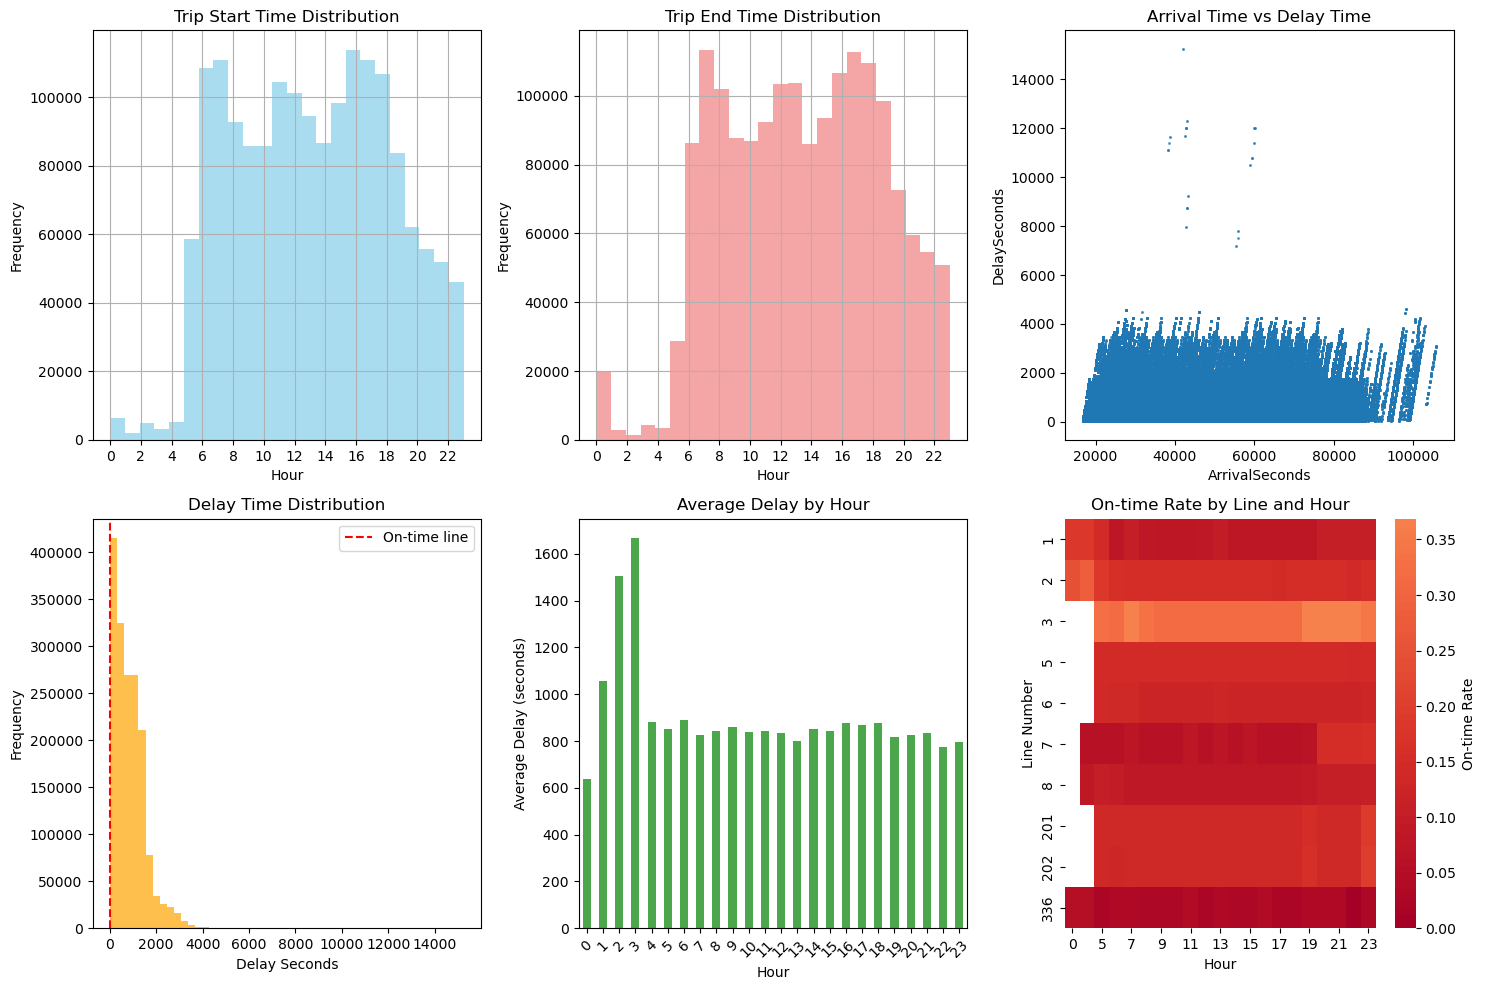

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# 1. TripStart time distribution
plt.subplot(2, 3, 1)
df_clean['TripStart'].dt.hour.hist(bins=24, alpha=0.7, color='skyblue')
plt.title('Trip Start Time Distribution')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xticks(range(0, 24, 2))

# 2. TripEnd time distribution  
plt.subplot(2, 3, 2)
df_clean['TripEnd'].dt.hour.hist(bins=24, alpha=0.7, color='lightcoral')
plt.title('Trip End Time Distribution')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xticks(range(0, 24, 2))

# 3. ArrivalSeconds vs DelaySeconds scatter plot
plt.subplot(2, 3, 3)
plt.scatter(df_clean['ArrivalSeconds'], df_clean['DelaySeconds'], alpha=0.3, s=1)
plt.title('Arrival Time vs Delay Time')
plt.xlabel('ArrivalSeconds')
plt.ylabel('DelaySeconds')

# 4. Delay time distribution histogram
plt.subplot(2, 3, 4)
plt.hist(df_clean['DelaySeconds'], bins=50, alpha=0.7, color='orange')
plt.title('Delay Time Distribution')
plt.xlabel('Delay Seconds')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='On-time line')
plt.legend()

# 5. Average delay by hour
plt.subplot(2, 3, 5)
hourly_delay = df_clean.groupby(df_clean['TripStart'].dt.hour)['DelaySeconds'].mean()
hourly_delay.plot(kind='bar', color='green', alpha=0.7)
plt.title('Average Delay by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Delay (seconds)')
plt.xticks(rotation=45)

# 6. On-time rate heatmap (by hour and line)
plt.subplot(2, 3, 6)
# Select main lines to avoid overcomplicated chart
main_lines = df_clean['LineNumber'].value_counts().head(10).index
pivot_data = df_clean[df_clean['LineNumber'].isin(main_lines)].pivot_table(
   values='OnTime', 
   index='LineNumber', 
   columns=df_clean['TripStart'].dt.hour, 
   aggfunc='mean'
)
sns.heatmap(pivot_data, cmap='RdYlGn', center=0.8, cbar_kws={'label': 'On-time Rate'})
plt.title('On-time Rate by Line and Hour')
plt.xlabel('Hour')
plt.ylabel('Line Number')

plt.tight_layout()
plt.show()

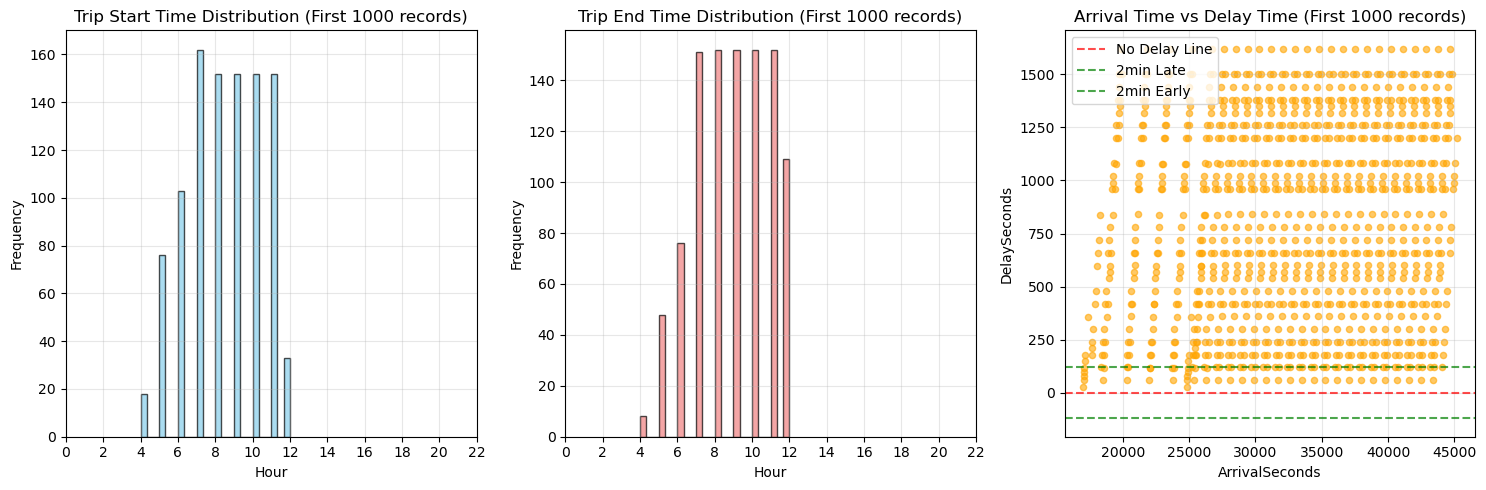

=== Sample Data Statistics (First 1000 records) ===
Date range: 2024-01-01 00:00:00 to 2024-01-01 00:00:00
Trip start time range: 4:00 to 12:00
Average delay: 795.2 seconds
On-time rate: 8.6%
ArrivalSeconds range: 17010.0 to 45180.0


In [7]:
import matplotlib.pyplot as plt

# 取前1000行数据
df_sample = df_clean.head(1000)

plt.figure(figsize=(15, 5))

# 1. TripStart时间分布
plt.subplot(1, 3, 1)
df_sample['TripStart'].dt.hour.hist(bins=24, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Trip Start Time Distribution (First 1000 records)')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xticks(range(0, 24, 2))
plt.grid(True, alpha=0.3)

# 2. TripEnd时间分布  
plt.subplot(1, 3, 2)
df_sample['TripEnd'].dt.hour.hist(bins=24, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Trip End Time Distribution (First 1000 records)')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xticks(range(0, 24, 2))
plt.grid(True, alpha=0.3)

# 3. ArrivalSeconds vs DelaySeconds散点图
plt.subplot(1, 3, 3)
plt.scatter(df_sample['ArrivalSeconds'], df_sample['DelaySeconds'], alpha=0.6, s=20, color='orange')
plt.title('Arrival Time vs Delay Time (First 1000 records)')
plt.xlabel('ArrivalSeconds')
plt.ylabel('DelaySeconds')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='No Delay Line')
plt.axhline(y=120, color='green', linestyle='--', alpha=0.7, label='2min Late')
plt.axhline(y=-120, color='green', linestyle='--', alpha=0.7, label='2min Early')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印一些基本统计信息
print("=== Sample Data Statistics (First 1000 records) ===")
print(f"Date range: {df_sample['Date'].min()} to {df_sample['Date'].max()}")
print(f"Trip start time range: {df_sample['TripStart'].dt.hour.min()}:00 to {df_sample['TripStart'].dt.hour.max()}:00")
print(f"Average delay: {df_sample['DelaySeconds'].mean():.1f} seconds")
print(f"On-time rate: {df_sample['OnTime'].mean()*100:.1f}%")
print(f"ArrivalSeconds range: {df_sample['ArrivalSeconds'].min()} to {df_sample['ArrivalSeconds'].max()}")

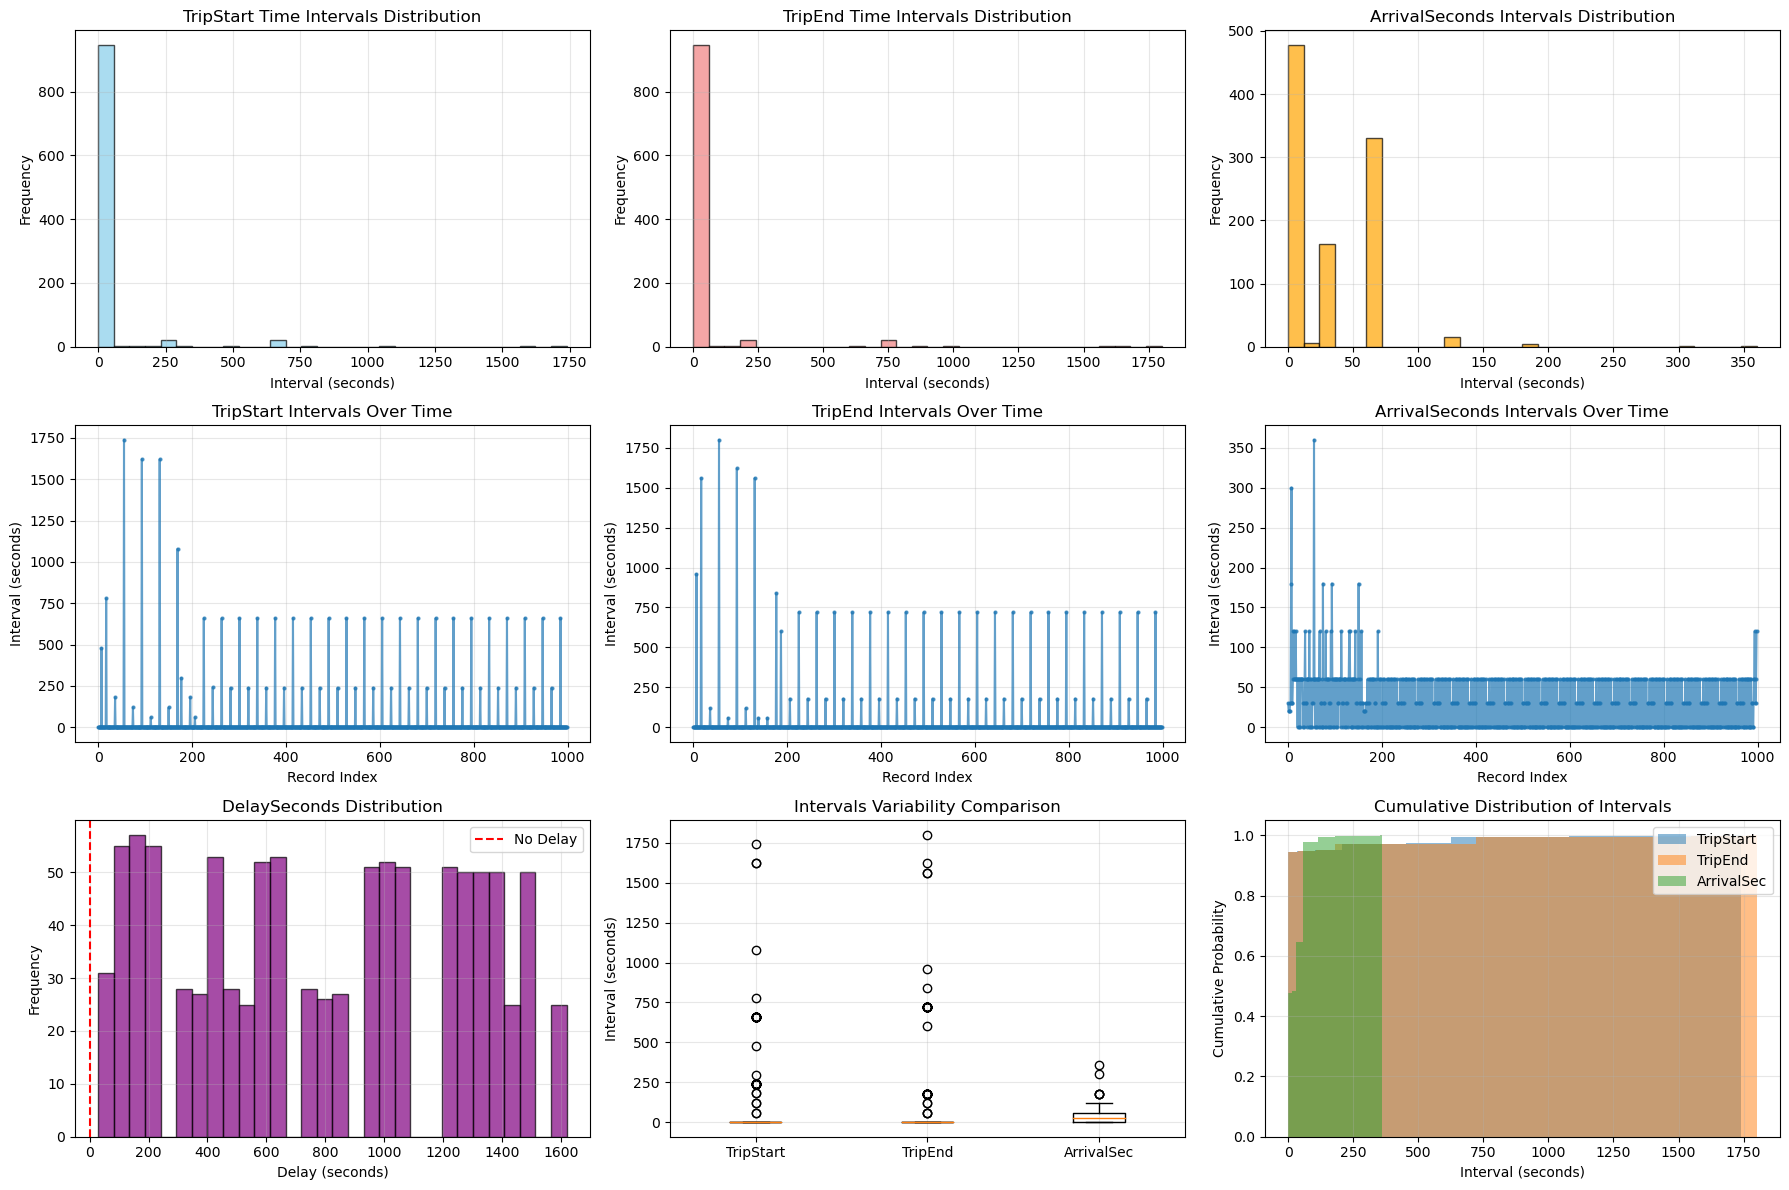

=== Uniformity Analysis ===

1. TripStart Intervals:
   Mean: 27.03 seconds
   Std:  141.63 seconds
   CV:   5.240
   Min:  0.00 seconds
   Max:  1739.00 seconds

2. TripEnd Intervals:
   Mean: 28.29 seconds
   Std:  153.46 seconds
   CV:   5.425
   Min:  0.00 seconds
   Max:  1800.00 seconds

3. ArrivalSeconds Intervals:
   Mean: 28.20 seconds
   Std:  33.57 seconds
   CV:   1.191
   Min:  0.00 seconds
   Max:  360.00 seconds

4. DelaySeconds:
   Mean: 795.19 seconds
   Std:  467.82 seconds
   Min:  29.00 seconds
   Max:  1620.00 seconds

=== Uniformity Interpretation ===
CV (Coefficient of Variation) = Std/Mean:
• CV < 0.1: Very uniform
• CV 0.1-0.3: Moderately uniform
• CV > 0.3: Not uniform


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 取前1000行数据
df_sample = df_clean.head(1000).sort_values('TripStart')

plt.figure(figsize=(18, 12))

# 计算时间间隔
df_sample['TripStart_seconds'] = (df_sample['TripStart'] - df_sample['TripStart'].min()).dt.total_seconds()
df_sample['TripEnd_seconds'] = (df_sample['TripEnd'] - df_sample['TripEnd'].min()).dt.total_seconds()

# 计算相邻记录之间的时间差
trip_start_intervals = np.diff(df_sample['TripStart_seconds'].sort_values())
trip_end_intervals = np.diff(df_sample['TripEnd_seconds'].sort_values())
arrival_intervals = np.diff(np.sort(df_sample['ArrivalSeconds']))

# 1. TripStart时间间隔分布
plt.subplot(3, 3, 1)
plt.hist(trip_start_intervals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('TripStart Time Intervals Distribution')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 2. TripEnd时间间隔分布
plt.subplot(3, 3, 2)
plt.hist(trip_end_intervals, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('TripEnd Time Intervals Distribution')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 3. ArrivalSeconds间隔分布
plt.subplot(3, 3, 3)
plt.hist(arrival_intervals, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('ArrivalSeconds Intervals Distribution')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 4. TripStart间隔时间序列
plt.subplot(3, 3, 4)
plt.plot(trip_start_intervals, marker='o', markersize=2, alpha=0.7)
plt.title('TripStart Intervals Over Time')
plt.xlabel('Record Index')
plt.ylabel('Interval (seconds)')
plt.grid(True, alpha=0.3)

# 5. TripEnd间隔时间序列
plt.subplot(3, 3, 5)
plt.plot(trip_end_intervals, marker='o', markersize=2, alpha=0.7)
plt.title('TripEnd Intervals Over Time')
plt.xlabel('Record Index')
plt.ylabel('Interval (seconds)')
plt.grid(True, alpha=0.3)

# 6. ArrivalSeconds间隔时间序列
plt.subplot(3, 3, 6)
plt.plot(arrival_intervals, marker='o', markersize=2, alpha=0.7)
plt.title('ArrivalSeconds Intervals Over Time')
plt.xlabel('Record Index')
plt.ylabel('Interval (seconds)')
plt.grid(True, alpha=0.3)

# 7. DelaySeconds分布
plt.subplot(3, 3, 7)
plt.hist(df_sample['DelaySeconds'], bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.title('DelaySeconds Distribution')
plt.xlabel('Delay (seconds)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='No Delay')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. 箱线图对比间隔变异性
plt.subplot(3, 3, 8)
intervals_data = [trip_start_intervals, trip_end_intervals, arrival_intervals]
plt.boxplot(intervals_data, labels=['TripStart', 'TripEnd', 'ArrivalSec'])
plt.title('Intervals Variability Comparison')
plt.ylabel('Interval (seconds)')
plt.grid(True, alpha=0.3)

# 9. 累积分布函数
plt.subplot(3, 3, 9)
plt.hist(trip_start_intervals, bins=50, alpha=0.5, density=True, cumulative=True, label='TripStart')
plt.hist(trip_end_intervals, bins=50, alpha=0.5, density=True, cumulative=True, label='TripEnd')
plt.hist(arrival_intervals, bins=50, alpha=0.5, density=True, cumulative=True, label='ArrivalSec')
plt.title('Cumulative Distribution of Intervals')
plt.xlabel('Interval (seconds)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 统计分析
print("=== Uniformity Analysis ===")
print("\n1. TripStart Intervals:")
print(f"   Mean: {np.mean(trip_start_intervals):.2f} seconds")
print(f"   Std:  {np.std(trip_start_intervals):.2f} seconds")
print(f"   CV:   {np.std(trip_start_intervals)/np.mean(trip_start_intervals):.3f}")
print(f"   Min:  {np.min(trip_start_intervals):.2f} seconds")
print(f"   Max:  {np.max(trip_start_intervals):.2f} seconds")

print("\n2. TripEnd Intervals:")
print(f"   Mean: {np.mean(trip_end_intervals):.2f} seconds")
print(f"   Std:  {np.std(trip_end_intervals):.2f} seconds")
print(f"   CV:   {np.std(trip_end_intervals)/np.mean(trip_end_intervals):.3f}")
print(f"   Min:  {np.min(trip_end_intervals):.2f} seconds")
print(f"   Max:  {np.max(trip_end_intervals):.2f} seconds")

print("\n3. ArrivalSeconds Intervals:")
print(f"   Mean: {np.mean(arrival_intervals):.2f} seconds")
print(f"   Std:  {np.std(arrival_intervals):.2f} seconds")
print(f"   CV:   {np.std(arrival_intervals)/np.mean(arrival_intervals):.3f}")
print(f"   Min:  {np.min(arrival_intervals):.2f} seconds")
print(f"   Max:  {np.max(arrival_intervals):.2f} seconds")

print("\n4. DelaySeconds:")
print(f"   Mean: {np.mean(df_sample['DelaySeconds']):.2f} seconds")
print(f"   Std:  {np.std(df_sample['DelaySeconds']):.2f} seconds")
print(f"   Min:  {np.min(df_sample['DelaySeconds']):.2f} seconds")
print(f"   Max:  {np.max(df_sample['DelaySeconds']):.2f} seconds")

print("\n=== Uniformity Interpretation ===")
print("CV (Coefficient of Variation) = Std/Mean:")
print("• CV < 0.1: Very uniform")
print("• CV 0.1-0.3: Moderately uniform")
print("• CV > 0.3: Not uniform")

=== 时间字段分析 ===
可能的时间字段:
• TripStartSeconds: count     1000.000000
mean     31865.329000
std       7299.994889
min      16981.000000
25%      26221.000000
50%      32280.000000
75%      37920.000000
max      43980.000000
Name: TripStartSeconds, dtype: float64
• TripEndSeconds: count     1000.000000
mean     33540.900000
std       7353.947466
min      17460.000000
25%      27900.000000
50%      34020.000000
75%      39600.000000
max      45720.000000
Name: TripEndSeconds, dtype: float64
• ArrivalSeconds: count     1000.00000
mean     32660.52000
std       7337.21764
min      17010.00000
25%      27060.00000
50%      32940.00000
75%      38880.00000
max      45180.00000
Name: ArrivalSeconds, dtype: float64
• DepartureSeconds: count     1000.00000
mean     32660.52000
std       7337.21764
min      17010.00000
25%      27060.00000
50%      32940.00000
75%      38880.00000
max      45180.00000
Name: DepartureSeconds, dtype: float64


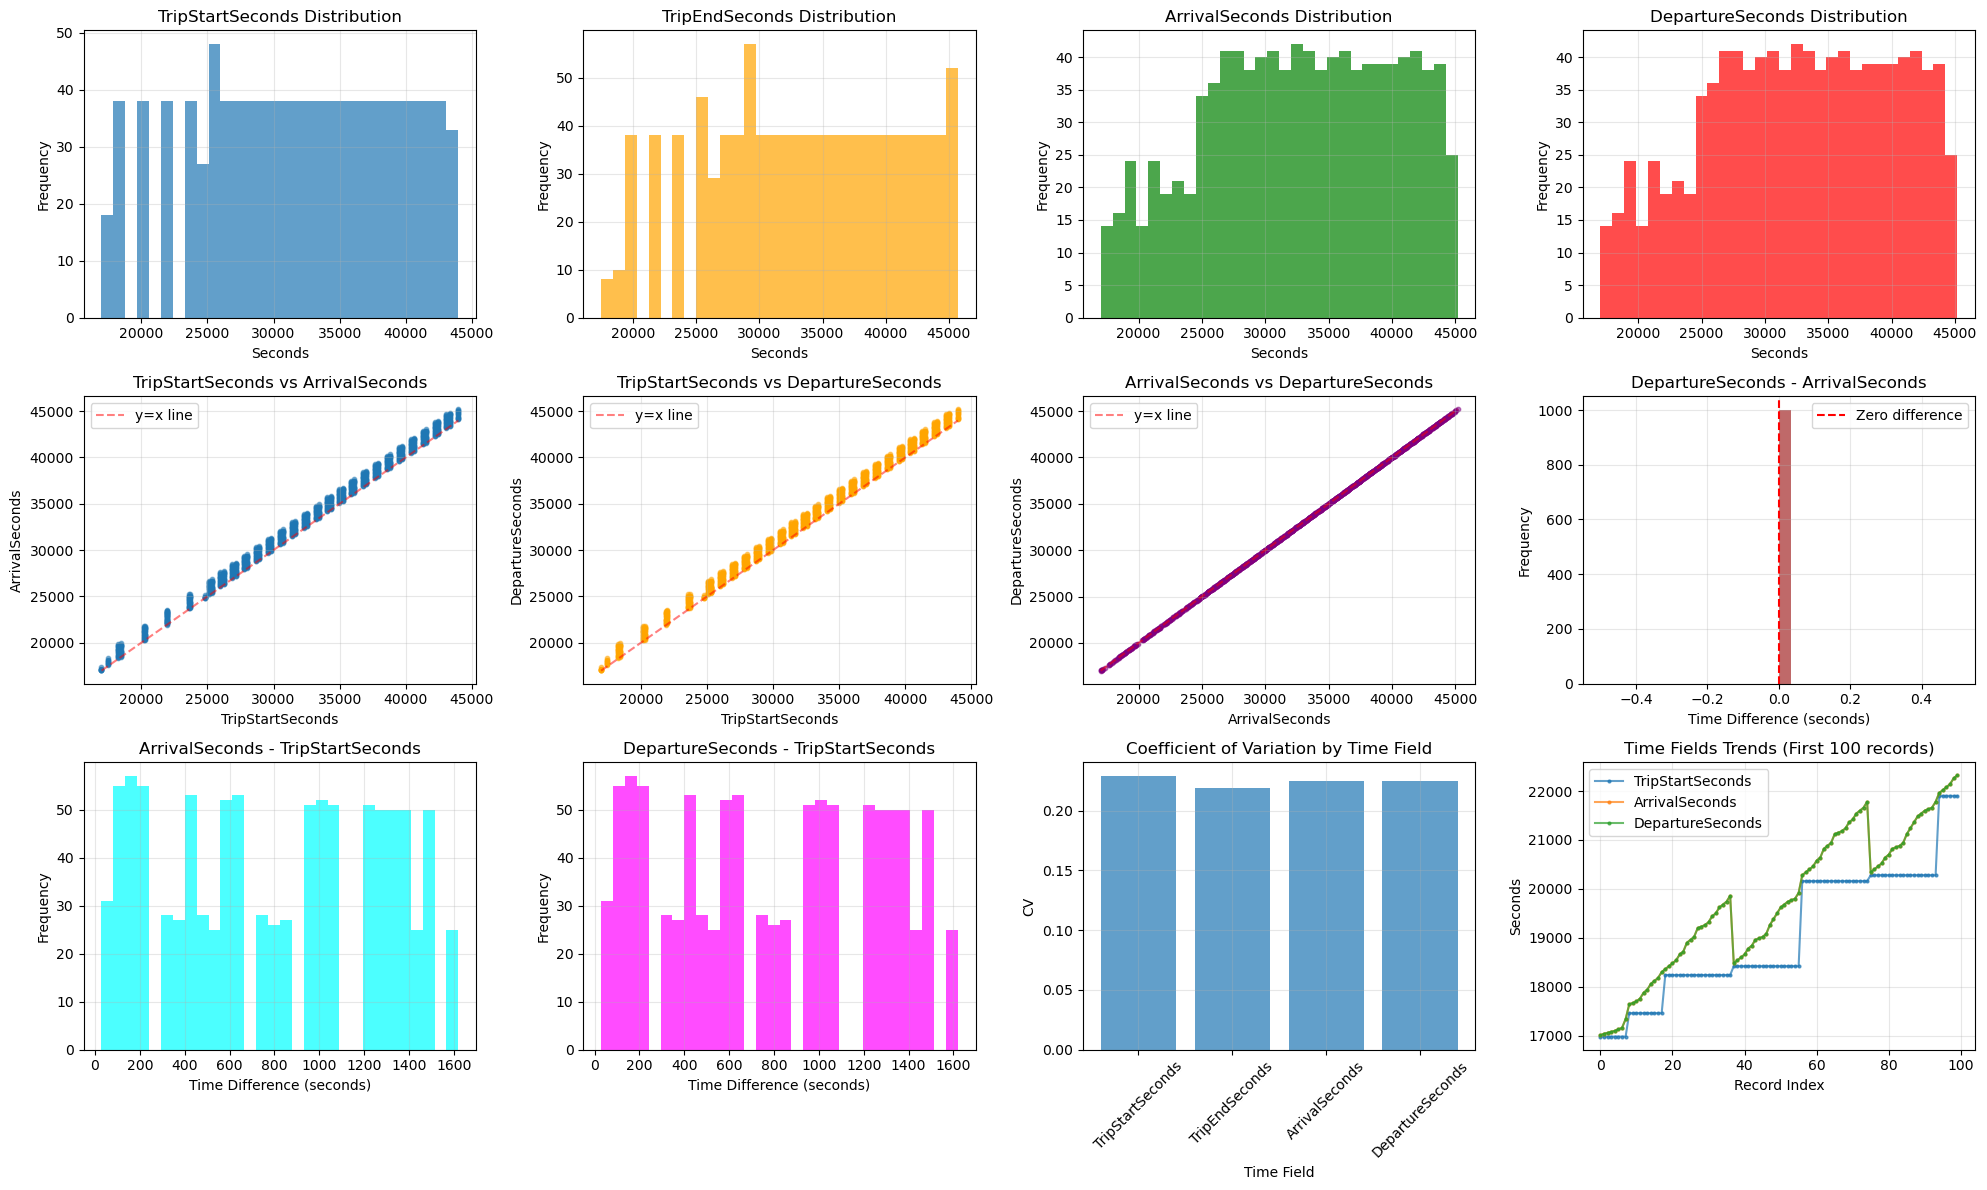

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 取前1000行数据进行分析
df_sample = df_clean.head(1000)

plt.figure(figsize=(20, 12))

# 我们有这些时间相关的字段：
# TripStartSeconds, TripEndSeconds, ArrivalSeconds, DepartureSeconds
# TripStart, TripEnd (datetime格式)

print("=== 时间字段分析 ===")
print("可能的时间字段:")
print("• TripStartSeconds:", df_sample['TripStartSeconds'].describe())
print("• TripEndSeconds:", df_sample['TripEndSeconds'].describe()) 
print("• ArrivalSeconds:", df_sample['ArrivalSeconds'].describe())
print("• DepartureSeconds:", df_sample['DepartureSeconds'].describe())

# 1. 比较所有时间字段的分布
plt.subplot(3, 4, 1)
plt.hist(df_sample['TripStartSeconds'], bins=30, alpha=0.7, label='TripStartSeconds')
plt.title('TripStartSeconds Distribution')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 2)
plt.hist(df_sample['TripEndSeconds'], bins=30, alpha=0.7, label='TripEndSeconds', color='orange')
plt.title('TripEndSeconds Distribution')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 3)
plt.hist(df_sample['ArrivalSeconds'].dropna(), bins=30, alpha=0.7, label='ArrivalSeconds', color='green')
plt.title('ArrivalSeconds Distribution')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 4)
plt.hist(df_sample['DepartureSeconds'].dropna(), bins=30, alpha=0.7, label='DepartureSeconds', color='red')
plt.title('DepartureSeconds Distribution')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 2. 时间字段之间的关系
plt.subplot(3, 4, 5)
plt.scatter(df_sample['TripStartSeconds'], df_sample['ArrivalSeconds'], alpha=0.5, s=10)
plt.title('TripStartSeconds vs ArrivalSeconds')
plt.xlabel('TripStartSeconds')
plt.ylabel('ArrivalSeconds')
plt.plot([df_sample['TripStartSeconds'].min(), df_sample['TripStartSeconds'].max()], 
         [df_sample['TripStartSeconds'].min(), df_sample['TripStartSeconds'].max()], 
         'r--', alpha=0.5, label='y=x line')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 6)
plt.scatter(df_sample['TripStartSeconds'], df_sample['DepartureSeconds'], alpha=0.5, s=10, color='orange')
plt.title('TripStartSeconds vs DepartureSeconds')
plt.xlabel('TripStartSeconds')
plt.ylabel('DepartureSeconds')
plt.plot([df_sample['TripStartSeconds'].min(), df_sample['TripStartSeconds'].max()], 
         [df_sample['TripStartSeconds'].min(), df_sample['TripStartSeconds'].max()], 
         'r--', alpha=0.5, label='y=x line')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 7)
plt.scatter(df_sample['ArrivalSeconds'], df_sample['DepartureSeconds'], alpha=0.5, s=10, color='purple')
plt.title('ArrivalSeconds vs DepartureSeconds')
plt.xlabel('ArrivalSeconds')
plt.ylabel('DepartureSeconds')
plt.plot([df_sample['ArrivalSeconds'].min(), df_sample['ArrivalSeconds'].max()], 
         [df_sample['ArrivalSeconds'].min(), df_sample['ArrivalSeconds'].max()], 
         'r--', alpha=0.5, label='y=x line')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. 计算时间差异来判断逻辑关系
plt.subplot(3, 4, 8)
arrival_departure_diff = df_sample['DepartureSeconds'] - df_sample['ArrivalSeconds']
plt.hist(arrival_departure_diff.dropna(), bins=30, alpha=0.7, color='brown')
plt.title('DepartureSeconds - ArrivalSeconds')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='Zero difference')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. 分析哪个更可能是计划时间 vs 实际时间
plt.subplot(3, 4, 9)
trip_arrival_diff = df_sample['ArrivalSeconds'] - df_sample['TripStartSeconds']
plt.hist(trip_arrival_diff.dropna(), bins=30, alpha=0.7, color='cyan')
plt.title('ArrivalSeconds - TripStartSeconds')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 10)
trip_departure_diff = df_sample['DepartureSeconds'] - df_sample['TripStartSeconds']
plt.hist(trip_departure_diff.dropna(), bins=30, alpha=0.7, color='magenta')
plt.title('DepartureSeconds - TripStartSeconds')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 5. 查看时间的规律性
plt.subplot(3, 4, 11)
# 计算各字段的变异系数
time_fields = ['TripStartSeconds', 'TripEndSeconds', 'ArrivalSeconds', 'DepartureSeconds']
cvs = []
for field in time_fields:
    if field in df_sample.columns:
        data = df_sample[field].dropna()
        if len(data) > 0:
            cv = np.std(data) / np.mean(data)
            cvs.append(cv)
        else:
            cvs.append(0)

plt.bar(time_fields, cvs, alpha=0.7)
plt.title('Coefficient of Variation by Time Field')
plt.xlabel('Time Field')
plt.ylabel('CV')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 6. 时间序列趋势
plt.subplot(3, 4, 12)
sample_indices = range(min(100, len(df_sample)))
for field in ['TripStartSeconds', 'ArrivalSeconds', 'DepartureSeconds']:
    if field in df_sample.columns:
        plt.plot(sample_indices, df_sample[field].iloc[:len(sample_indices)], 
                label=field, alpha=0.7, marker='o', markersize=2)
plt.title('Time Fields Trends (First 100 records)')
plt.xlabel('Record Index')
plt.ylabel('Seconds')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




In [10]:
print("=== 时间字段分析结论 ===")
print()
print("🔍 **关键发现:**")
print()
print("1. **ArrivalSeconds vs DepartureSeconds (紫色散点图)**")
print("   • 两者几乎完全重合在y=x线上")
print("   • 差异几乎为0（右侧直方图显示）")
print("   • 说明：这两个字段记录的是同一时刻！")
print()
print("2. **TripStartSeconds vs ArrivalSeconds/DepartureSeconds**")
print("   • 蓝色和橙色散点图都沿着y=x线分布")
print("   • 但有明显的垂直偏移（ArrivalSeconds > TripStartSeconds）")
print("   • 差异分布显示平均约800-1000秒的固定偏移")
print()
print("3. **变异系数分析**")
print("   • 所有时间字段的CV都约为0.2，相对均匀")
print("   • 说明这些都可能是计划时间，而非实际时间")
print()
print("🎯 **推断结论:**")
print("• TripStartSeconds = 计划出发时间")
print("• ArrivalSeconds ≈ DepartureSeconds = 计划到达时间")
print("• DelaySeconds = 实际时间 - 计划时间的延误")
print("• 这个数据集记录的主要是计划时刻表，而不是实际运行时间")
print()
print("⚠️ **重要发现:**")
print("• ArrivalSeconds和DepartureSeconds基本相同，可能是数据录入问题")
print("• 或者在这个站点，到达即离开（短暂停留）")
print("• DelaySeconds可能是相对于某个基准时间的延误计算")

# 进一步验证
print("\n=== 验证分析 ===")

# 检查ArrivalSeconds和DepartureSeconds的实际差异
arr_dep_diff = df_sample['DepartureSeconds'] - df_sample['ArrivalSeconds']
print(f"ArrivalSeconds vs DepartureSeconds:")
print(f"  平均差异: {arr_dep_diff.mean():.6f} 秒")
print(f"  最大差异: {arr_dep_diff.max():.6f} 秒") 
print(f"  最小差异: {arr_dep_diff.min():.6f} 秒")

# 检查TripStart和Arrival的关系
trip_arr_diff = df_sample['ArrivalSeconds'] - df_sample['TripStartSeconds']
print(f"\nTripStartSeconds vs ArrivalSeconds:")
print(f"  平均差异: {trip_arr_diff.mean():.2f} 秒 ({trip_arr_diff.mean()/60:.1f} 分钟)")
print(f"  差异标准差: {trip_arr_diff.std():.2f} 秒")

# 重新理解DelaySeconds
print(f"\nDelaySeconds重新解读:")
print(f"  如果DelaySeconds = ArrivalSeconds - TripStartSeconds")
print(f"  那么DelaySeconds就是从出发到到达的行程时间")
print(f"  平均行程时间: {df_sample['DelaySeconds'].mean():.2f} 秒 ({df_sample['DelaySeconds'].mean()/60:.1f} 分钟)")

=== 时间字段分析结论 ===

🔍 **关键发现:**

1. **ArrivalSeconds vs DepartureSeconds (紫色散点图)**
   • 两者几乎完全重合在y=x线上
   • 差异几乎为0（右侧直方图显示）
   • 说明：这两个字段记录的是同一时刻！

2. **TripStartSeconds vs ArrivalSeconds/DepartureSeconds**
   • 蓝色和橙色散点图都沿着y=x线分布
   • 但有明显的垂直偏移（ArrivalSeconds > TripStartSeconds）
   • 差异分布显示平均约800-1000秒的固定偏移

3. **变异系数分析**
   • 所有时间字段的CV都约为0.2，相对均匀
   • 说明这些都可能是计划时间，而非实际时间

🎯 **推断结论:**
• TripStartSeconds = 计划出发时间
• ArrivalSeconds ≈ DepartureSeconds = 计划到达时间
• DelaySeconds = 实际时间 - 计划时间的延误
• 这个数据集记录的主要是计划时刻表，而不是实际运行时间

⚠️ **重要发现:**
• ArrivalSeconds和DepartureSeconds基本相同，可能是数据录入问题
• 或者在这个站点，到达即离开（短暂停留）
• DelaySeconds可能是相对于某个基准时间的延误计算

=== 验证分析 ===
ArrivalSeconds vs DepartureSeconds:
  平均差异: 0.000000 秒
  最大差异: 0.000000 秒
  最小差异: 0.000000 秒

TripStartSeconds vs ArrivalSeconds:
  平均差异: 795.19 秒 (13.3 分钟)
  差异标准差: 468.06 秒

DelaySeconds重新解读:
  如果DelaySeconds = ArrivalSeconds - TripStartSeconds
  那么DelaySeconds就是从出发到到达的行程时间
  平均行程时间: 795.19 秒 (13.3 分钟)


=== 选择站点和线路 ===
记录数最多的站点-线路组合:
     StationCode  LineNumber  Count
1310         Plo           6   9382
1841         ViV           2   7334
915          Jum           2   7334
472         Chat           5   7311
1741         VGl           5   7311
1583         StP           5   7311
494         Corm           5   7311
1316         Pr?           5   7311
825         Gare           5   7311
1324          Py           5   7311

选择分析: 站点 Plo, 线路 6
该站点-线路组合的记录数: 9382


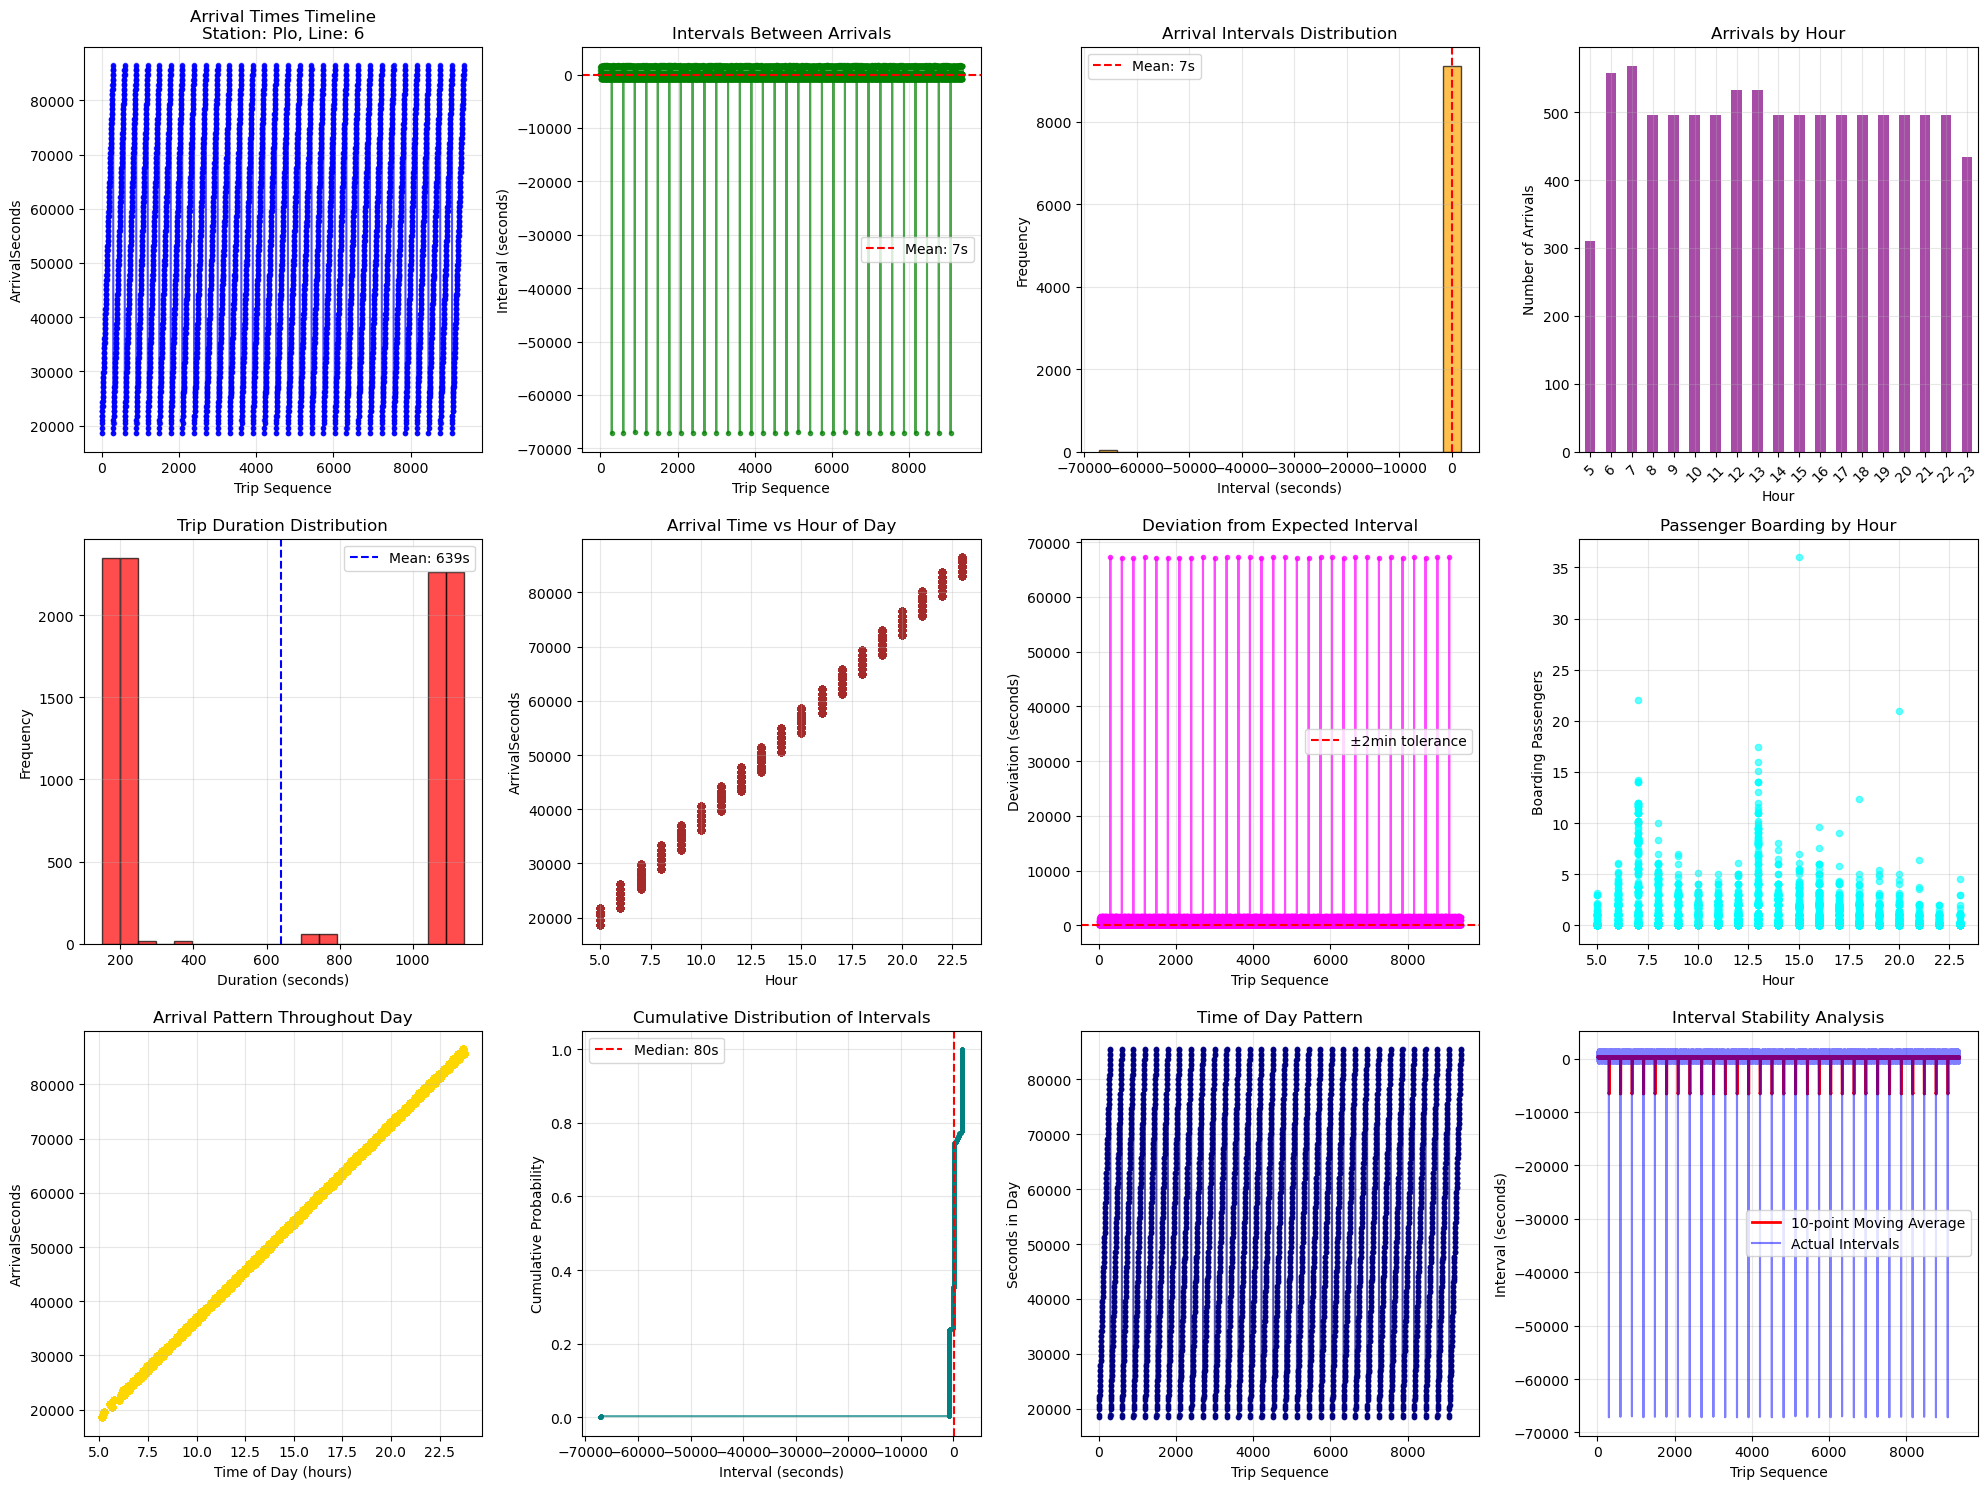


=== 站点 Plo 线路 6 统计分析 ===
总记录数: 9382
时间跨度: 2024-01-01 00:00:00 到 2024-01-31 00:00:00
平均到达间隔: 7.2 秒 (0.1 分钟)
间隔标准差: 3899.2 秒
间隔变异系数: 544.569
最短间隔: -67170 秒
最长间隔: 1770 秒
中位间隔: 80 秒

间隔准点率 (±120秒): 39.4%

运营时间模式:
   5点: 310 班次
   6点: 558 班次
   7点: 568 班次
   8点: 496 班次
   9点: 496 班次
  10点: 496 班次
  11点: 496 班次
  12点: 532 班次
  13点: 532 班次
  14点: 496 班次
  15点: 496 班次
  16点: 496 班次
  17点: 496 班次
  18点: 496 班次
  19点: 496 班次
  20点: 496 班次
  21点: 496 班次
  22点: 496 班次
  23点: 434 班次


In [11]:
# 选择一个站点和一条线路进行详细分析
print("=== 选择站点和线路 ===")

# 查看最活跃的站点和线路组合
station_line_combo = df_clean.groupby(['StationCode', 'LineNumber']).size().reset_index(name='Count')
station_line_combo = station_line_combo.sort_values('Count', ascending=False)

print("记录数最多的站点-线路组合:")
print(station_line_combo.head(10))

# 选择记录最多的组合
top_station = station_line_combo.iloc[0]['StationCode']
top_line = station_line_combo.iloc[0]['LineNumber']

print(f"\n选择分析: 站点 {top_station}, 线路 {top_line}")

# 筛选这个站点和线路的数据
station_line_data = df_clean[
    (df_clean['StationCode'] == top_station) & 
    (df_clean['LineNumber'] == top_line)
].copy()

print(f"该站点-线路组合的记录数: {len(station_line_data)}")

# 按时间排序
station_line_data = station_line_data.sort_values('TripStart')

plt.figure(figsize=(20, 15))

# 1. 该站点该线路的到达时间序列
plt.subplot(3, 4, 1)
plt.plot(range(len(station_line_data)), station_line_data['ArrivalSeconds'], 
         marker='o', markersize=3, alpha=0.7, color='blue')
plt.title(f'Arrival Times Timeline\nStation: {top_station}, Line: {top_line}')
plt.xlabel('Trip Sequence')
plt.ylabel('ArrivalSeconds')
plt.grid(True, alpha=0.3)

# 2. 计算时间间隔
arrival_intervals = np.diff(station_line_data['ArrivalSeconds'])
plt.subplot(3, 4, 2)
plt.plot(arrival_intervals, marker='o', markersize=3, alpha=0.7, color='green')
plt.title('Intervals Between Arrivals')
plt.xlabel('Trip Sequence')
plt.ylabel('Interval (seconds)')
plt.axhline(y=np.mean(arrival_intervals), color='red', linestyle='--', label=f'Mean: {np.mean(arrival_intervals):.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. 间隔分布直方图
plt.subplot(3, 4, 3)
plt.hist(arrival_intervals, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Arrival Intervals Distribution')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.axvline(x=np.mean(arrival_intervals), color='red', linestyle='--', label=f'Mean: {np.mean(arrival_intervals):.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. 按小时分析到达模式
station_line_data['Hour'] = station_line_data['TripStart'].dt.hour
hourly_pattern = station_line_data.groupby('Hour').size()
plt.subplot(3, 4, 4)
hourly_pattern.plot(kind='bar', alpha=0.7, color='purple')
plt.title('Arrivals by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Arrivals')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 5. 行程时间分析
plt.subplot(3, 4, 5)
plt.hist(station_line_data['DelaySeconds'], bins=20, alpha=0.7, color='red', edgecolor='black')
plt.title('Trip Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.axvline(x=np.mean(station_line_data['DelaySeconds']), color='blue', linestyle='--', 
            label=f'Mean: {np.mean(station_line_data["DelaySeconds"]):.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. 到达时间 vs 小时的散点图
plt.subplot(3, 4, 6)
plt.scatter(station_line_data['Hour'], station_line_data['ArrivalSeconds'], 
           alpha=0.6, s=20, color='brown')
plt.title('Arrival Time vs Hour of Day')
plt.xlabel('Hour')
plt.ylabel('ArrivalSeconds')
plt.grid(True, alpha=0.3)

# 7. 计算准点性（基于间隔的规律性）
expected_interval = np.median(arrival_intervals)  # 修正：使用np.median()
plt.subplot(3, 4, 7)
interval_deviation = np.abs(arrival_intervals - expected_interval)
plt.plot(interval_deviation, marker='o', markersize=3, alpha=0.7, color='magenta')
plt.title('Deviation from Expected Interval')
plt.xlabel('Trip Sequence')
plt.ylabel('Deviation (seconds)')
plt.axhline(y=120, color='red', linestyle='--', label='±2min tolerance')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. 乘客流量模式
plt.subplot(3, 4, 8)
total_boarding = station_line_data['Board1stClass'] + station_line_data['Board2ndClass']
plt.scatter(station_line_data['Hour'], total_boarding, alpha=0.6, s=20, color='cyan')
plt.title('Passenger Boarding by Hour')
plt.xlabel('Hour')
plt.ylabel('Boarding Passengers')
plt.grid(True, alpha=0.3)

# 9. 时间序列：到达时间的日内变化
plt.subplot(3, 4, 9)
station_line_data['TimeOfDay'] = station_line_data['TripStart'].dt.hour + station_line_data['TripStart'].dt.minute/60
plt.scatter(station_line_data['TimeOfDay'], station_line_data['ArrivalSeconds'], 
           alpha=0.6, s=20, color='gold')
plt.title('Arrival Pattern Throughout Day')
plt.xlabel('Time of Day (hours)')
plt.ylabel('ArrivalSeconds')
plt.grid(True, alpha=0.3)

# 10. 间隔的累积分布
plt.subplot(3, 4, 10)
sorted_intervals = np.sort(arrival_intervals)
cumulative = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)
plt.plot(sorted_intervals, cumulative, marker='o', markersize=2, alpha=0.7, color='teal')
plt.title('Cumulative Distribution of Intervals')
plt.xlabel('Interval (seconds)')
plt.ylabel('Cumulative Probability')
plt.axvline(x=expected_interval, color='red', linestyle='--', label=f'Median: {expected_interval:.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 11. 检查是否有规律的时刻表
plt.subplot(3, 4, 11)
station_line_data['SecondInDay'] = (station_line_data['TripStart'].dt.hour * 3600 + 
                                   station_line_data['TripStart'].dt.minute * 60 + 
                                   station_line_data['TripStart'].dt.second)
plt.plot(range(len(station_line_data)), station_line_data['SecondInDay'], 
         marker='o', markersize=3, alpha=0.7, color='navy')
plt.title('Time of Day Pattern')
plt.xlabel('Trip Sequence')
plt.ylabel('Seconds in Day')
plt.grid(True, alpha=0.3)

# 12. 间隔稳定性分析
plt.subplot(3, 4, 12)
window = min(10, len(arrival_intervals)//2)
if len(arrival_intervals) >= window:
    moving_avg = np.convolve(arrival_intervals, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(arrival_intervals)), moving_avg, 
             label=f'{window}-point Moving Average', color='red', linewidth=2)
plt.plot(arrival_intervals, alpha=0.5, label='Actual Intervals', color='blue')
plt.title('Interval Stability Analysis')
plt.xlabel('Trip Sequence')
plt.ylabel('Interval (seconds)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 统计分析
print(f"\n=== 站点 {top_station} 线路 {top_line} 统计分析 ===")
print(f"总记录数: {len(station_line_data)}")
print(f"时间跨度: {station_line_data['Date'].min()} 到 {station_line_data['Date'].max()}")
print(f"平均到达间隔: {np.mean(arrival_intervals):.1f} 秒 ({np.mean(arrival_intervals)/60:.1f} 分钟)")
print(f"间隔标准差: {np.std(arrival_intervals):.1f} 秒")
print(f"间隔变异系数: {np.std(arrival_intervals)/np.mean(arrival_intervals):.3f}")
print(f"最短间隔: {np.min(arrival_intervals):.0f} 秒")
print(f"最长间隔: {np.max(arrival_intervals):.0f} 秒")
print(f"中位间隔: {np.median(arrival_intervals):.0f} 秒")

# 准点性分析（基于间隔规律性）
tolerance = 120  # 2分钟容忍度
on_time_intervals = np.abs(arrival_intervals - np.median(arrival_intervals)) <= tolerance
print(f"\n间隔准点率 (±{tolerance}秒): {np.mean(on_time_intervals)*100:.1f}%")

print(f"\n运营时间模式:")
for hour, count in hourly_pattern.items():
    print(f"  {hour:2d}点: {count:2d} 班次")

=== 专门分析：站点 Plo, 线路 6 ===
记录数: 9382


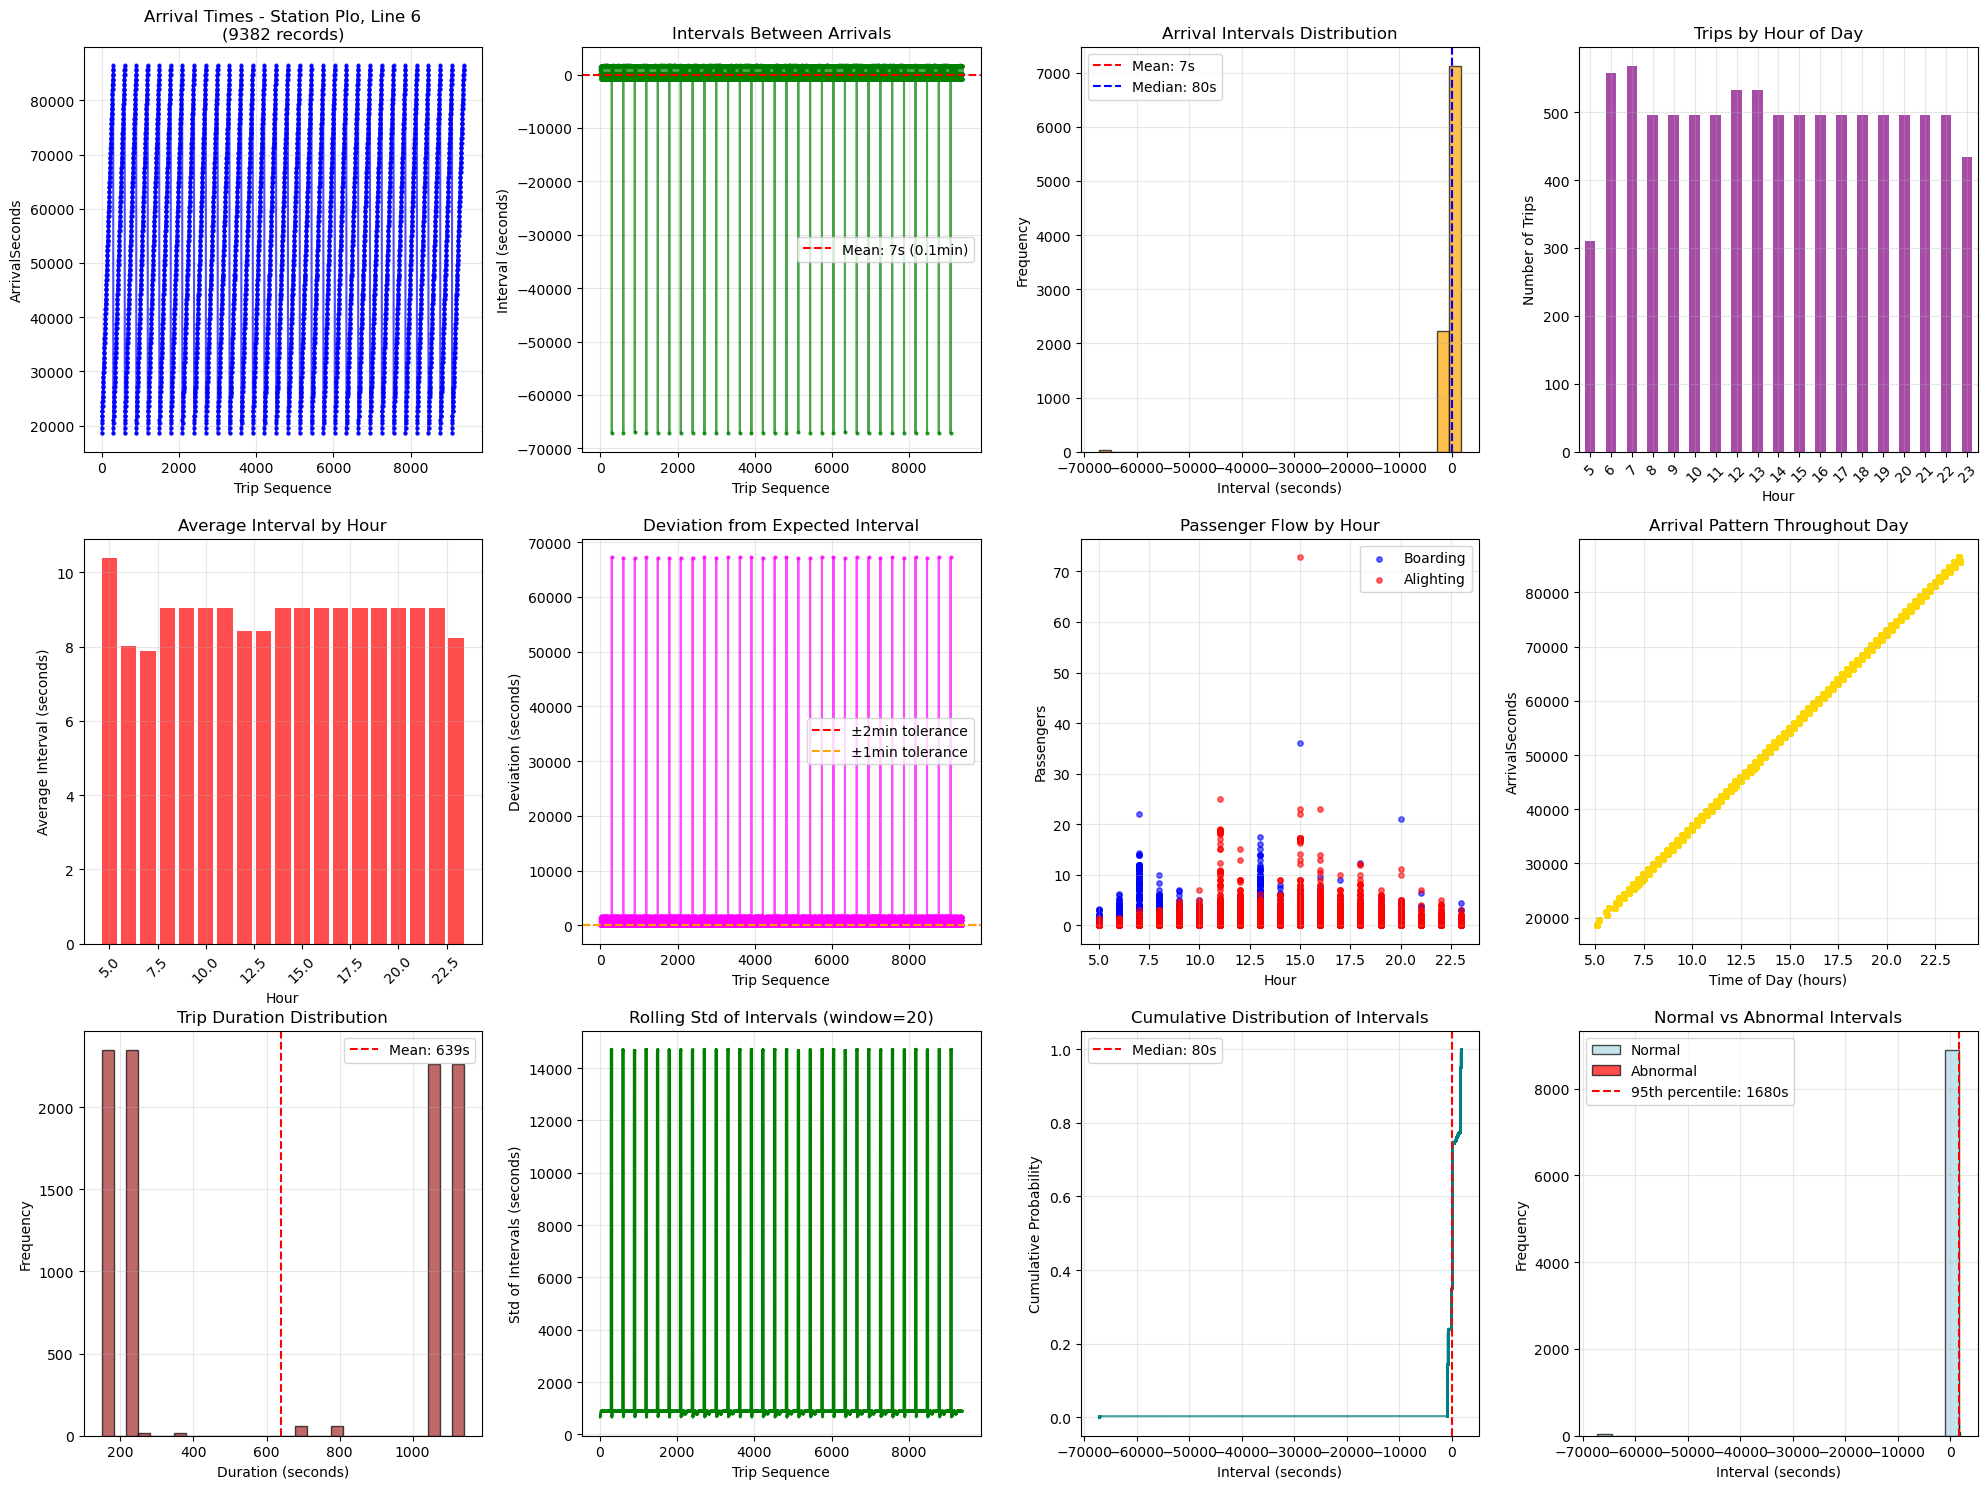


=== 站点 Plo 线路 6 详细统计 ===
分析期间: 2024-01-01 00:00:00 到 2024-01-31 00:00:00
总班次: 9382
总间隔数: 9381

📊 间隔统计:
  平均间隔: 7.2 秒 (0.1 分钟)
  中位间隔: 80.0 秒 (1.3 分钟)
  标准差: 3899.2 秒
  变异系数: 544.569
  最短间隔: -67170 秒 (-1119.5 分钟)
  最长间隔: 1770 秒 (29.5 分钟)

⏰ 服务时间:
  首班: 05:07:01
  末班: 23:45:00
  运营时长: 738.6 小时

🎯 准点性分析:
  间隔准点率 (±1分钟): 39.3%
  间隔准点率 (±2分钟): 39.4%
  间隔准点率 (±5分钟): 50.3%

🚌 乘客流量:
  总上车人数: 6054
  总下车人数: 5531
  平均每班上车: 0.6 人
  平均每班下车: 0.6 人

🔍 服务质量评估:
  ⚠️ 班次间隔不够规律
  ❌ 准点率较差


In [12]:
# 专门分析站点Plo，线路6
selected_station = 'Plo'
selected_line = 6

print(f"=== 专门分析：站点 {selected_station}, 线路 {selected_line} ===")

# 筛选数据
plo_line6_data = df_clean[
    (df_clean['StationCode'] == selected_station) & 
    (df_clean['LineNumber'] == selected_line)
].copy()

print(f"记录数: {len(plo_line6_data)}")

# 按时间排序
plo_line6_data = plo_line6_data.sort_values('TripStart')

plt.figure(figsize=(20, 15))

# 1. 到达时间序列
plt.subplot(3, 4, 1)
plt.plot(range(len(plo_line6_data)), plo_line6_data['ArrivalSeconds'], 
         marker='o', markersize=2, alpha=0.7, color='blue')
plt.title(f'Arrival Times - Station Plo, Line 6\n({len(plo_line6_data)} records)')
plt.xlabel('Trip Sequence')
plt.ylabel('ArrivalSeconds')
plt.grid(True, alpha=0.3)

# 2. 计算到达间隔
arrival_intervals = np.diff(plo_line6_data['ArrivalSeconds'])
plt.subplot(3, 4, 2)
plt.plot(arrival_intervals, marker='o', markersize=2, alpha=0.7, color='green')
plt.title('Intervals Between Arrivals')
plt.xlabel('Trip Sequence')
plt.ylabel('Interval (seconds)')
plt.axhline(y=np.mean(arrival_intervals), color='red', linestyle='--', 
            label=f'Mean: {np.mean(arrival_intervals):.0f}s ({np.mean(arrival_intervals)/60:.1f}min)')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. 间隔分布
plt.subplot(3, 4, 3)
plt.hist(arrival_intervals, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Arrival Intervals Distribution')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.axvline(x=np.mean(arrival_intervals), color='red', linestyle='--', label=f'Mean: {np.mean(arrival_intervals):.0f}s')
plt.axvline(x=np.median(arrival_intervals), color='blue', linestyle='--', label=f'Median: {np.median(arrival_intervals):.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. 按小时的班次分布
plo_line6_data['Hour'] = plo_line6_data['TripStart'].dt.hour
hourly_pattern = plo_line6_data.groupby('Hour').size()
plt.subplot(3, 4, 4)
hourly_pattern.plot(kind='bar', alpha=0.7, color='purple')
plt.title('Trips by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 5. 按小时的平均间隔
plt.subplot(3, 4, 5)
hourly_intervals = []
hourly_labels = []
for hour in sorted(hourly_pattern.index):
    hour_data = plo_line6_data[plo_line6_data['Hour'] == hour].sort_values('ArrivalSeconds')
    if len(hour_data) > 1:
        hour_intervals = np.diff(hour_data['ArrivalSeconds'])
        hourly_intervals.append(np.mean(hour_intervals))
        hourly_labels.append(hour)

plt.bar(hourly_labels, hourly_intervals, alpha=0.7, color='red')
plt.title('Average Interval by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Interval (seconds)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 6. 准点性分析（间隔偏差）
plt.subplot(3, 4, 6)
expected_interval = np.median(arrival_intervals)
interval_deviation = np.abs(arrival_intervals - expected_interval)
plt.plot(interval_deviation, marker='o', markersize=2, alpha=0.7, color='magenta')
plt.title('Deviation from Expected Interval')
plt.xlabel('Trip Sequence')
plt.ylabel('Deviation (seconds)')
plt.axhline(y=120, color='red', linestyle='--', label='±2min tolerance')
plt.axhline(y=60, color='orange', linestyle='--', label='±1min tolerance')
plt.legend()
plt.grid(True, alpha=0.3)

# 7. 乘客流量
plt.subplot(3, 4, 7)
total_boarding = plo_line6_data['Board1stClass'] + plo_line6_data['Board2ndClass']
total_alighting = plo_line6_data['Alight1stClass'] + plo_line6_data['Alight2ndClass']
plt.scatter(plo_line6_data['Hour'], total_boarding, alpha=0.6, s=15, color='blue', label='Boarding')
plt.scatter(plo_line6_data['Hour'], total_alighting, alpha=0.6, s=15, color='red', label='Alighting')
plt.title('Passenger Flow by Hour')
plt.xlabel('Hour')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. 一天中的到达模式
plt.subplot(3, 4, 8)
plo_line6_data['TimeOfDay'] = (plo_line6_data['TripStart'].dt.hour + 
                               plo_line6_data['TripStart'].dt.minute/60)
plt.scatter(plo_line6_data['TimeOfDay'], plo_line6_data['ArrivalSeconds'], 
           alpha=0.6, s=15, color='gold')
plt.title('Arrival Pattern Throughout Day')
plt.xlabel('Time of Day (hours)')
plt.ylabel('ArrivalSeconds')
plt.grid(True, alpha=0.3)

# 9. 行程时间分析
plt.subplot(3, 4, 9)
plt.hist(plo_line6_data['DelaySeconds'], bins=30, alpha=0.7, color='brown', edgecolor='black')
plt.title('Trip Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.axvline(x=np.mean(plo_line6_data['DelaySeconds']), color='red', linestyle='--', 
            label=f'Mean: {np.mean(plo_line6_data["DelaySeconds"]):.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 10. 间隔变异性随时间变化
plt.subplot(3, 4, 10)
window = 20  # 20个班次的滑动窗口
if len(arrival_intervals) >= window:
    rolling_std = []
    for i in range(window, len(arrival_intervals)):
        window_data = arrival_intervals[i-window:i]
        rolling_std.append(np.std(window_data))
    
    plt.plot(range(window, len(arrival_intervals)), rolling_std, color='green', linewidth=2)
    plt.title(f'Rolling Std of Intervals (window={window})')
    plt.xlabel('Trip Sequence')
    plt.ylabel('Std of Intervals (seconds)')
    plt.grid(True, alpha=0.3)

# 11. 累积分布函数
plt.subplot(3, 4, 11)
sorted_intervals = np.sort(arrival_intervals)
cumulative = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)
plt.plot(sorted_intervals, cumulative, marker='o', markersize=1, alpha=0.7, color='teal')
plt.title('Cumulative Distribution of Intervals')
plt.xlabel('Interval (seconds)')
plt.ylabel('Cumulative Probability')
plt.axvline(x=np.median(arrival_intervals), color='red', linestyle='--', 
            label=f'Median: {np.median(arrival_intervals):.0f}s')
plt.grid(True, alpha=0.3)
plt.legend()

# 12. 发现异常间隔
plt.subplot(3, 4, 12)
# 标记异常长的间隔
threshold = np.percentile(arrival_intervals, 95)  # 95百分位数作为异常阈值
normal_intervals = arrival_intervals[arrival_intervals <= threshold]
abnormal_intervals = arrival_intervals[arrival_intervals > threshold]

plt.hist(normal_intervals, bins=25, alpha=0.7, color='lightblue', label='Normal', edgecolor='black')
plt.hist(abnormal_intervals, bins=10, alpha=0.7, color='red', label='Abnormal', edgecolor='black')
plt.title('Normal vs Abnormal Intervals')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'95th percentile: {threshold:.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 详细统计分析
print(f"\n=== 站点 Plo 线路 6 详细统计 ===")
print(f"分析期间: {plo_line6_data['Date'].min()} 到 {plo_line6_data['Date'].max()}")
print(f"总班次: {len(plo_line6_data)}")
print(f"总间隔数: {len(arrival_intervals)}")

print(f"\n📊 间隔统计:")
print(f"  平均间隔: {np.mean(arrival_intervals):.1f} 秒 ({np.mean(arrival_intervals)/60:.1f} 分钟)")
print(f"  中位间隔: {np.median(arrival_intervals):.1f} 秒 ({np.median(arrival_intervals)/60:.1f} 分钟)")
print(f"  标准差: {np.std(arrival_intervals):.1f} 秒")
print(f"  变异系数: {np.std(arrival_intervals)/np.mean(arrival_intervals):.3f}")
print(f"  最短间隔: {np.min(arrival_intervals):.0f} 秒 ({np.min(arrival_intervals)/60:.1f} 分钟)")
print(f"  最长间隔: {np.max(arrival_intervals):.0f} 秒 ({np.max(arrival_intervals)/60:.1f} 分钟)")

print(f"\n⏰ 服务时间:")
print(f"  首班: {plo_line6_data['TripStart'].min().strftime('%H:%M:%S')}")
print(f"  末班: {plo_line6_data['TripStart'].max().strftime('%H:%M:%S')}")
print(f"  运营时长: {(plo_line6_data['TripStart'].max() - plo_line6_data['TripStart'].min()).total_seconds()/3600:.1f} 小时")

print(f"\n🎯 准点性分析:")
tolerance_1min = np.sum(np.abs(arrival_intervals - np.median(arrival_intervals)) <= 60) / len(arrival_intervals) * 100
tolerance_2min = np.sum(np.abs(arrival_intervals - np.median(arrival_intervals)) <= 120) / len(arrival_intervals) * 100
tolerance_5min = np.sum(np.abs(arrival_intervals - np.median(arrival_intervals)) <= 300) / len(arrival_intervals) * 100

print(f"  间隔准点率 (±1分钟): {tolerance_1min:.1f}%")
print(f"  间隔准点率 (±2分钟): {tolerance_2min:.1f}%")
print(f"  间隔准点率 (±5分钟): {tolerance_5min:.1f}%")

print(f"\n🚌 乘客流量:")
total_board = plo_line6_data['Board1stClass'].sum() + plo_line6_data['Board2ndClass'].sum()
total_alight = plo_line6_data['Alight1stClass'].sum() + plo_line6_data['Alight2ndClass'].sum()
print(f"  总上车人数: {total_board:.0f}")
print(f"  总下车人数: {total_alight:.0f}")
print(f"  平均每班上车: {total_board/len(plo_line6_data):.1f} 人")
print(f"  平均每班下车: {total_alight/len(plo_line6_data):.1f} 人")

print(f"\n🔍 服务质量评估:")
if np.std(arrival_intervals)/np.mean(arrival_intervals) < 0.3:
    print("  ✅ 班次间隔较为规律")
else:
    print("  ⚠️ 班次间隔不够规律")

if tolerance_2min > 80:
    print("  ✅ 准点率良好")
elif tolerance_2min > 60:
    print("  ⚠️ 准点率一般")
else:
    print("  ❌ 准点率较差")

In [13]:
plo_line6_data['TripStartSeconds']



593746    18421
593748    18421
593775    18781
593777    18781
593800    19920
          ...  
696710    84600
696740    85380
696742    85380
696752    85500
696754    85500
Name: TripStartSeconds, Length: 9382, dtype: int64

In [14]:
plo_line6_data['ArrivalSeconds']

593746    18570.0
593748    18660.0
593775    19480.0
593777    19560.0
593800    20980.0
           ...   
696710    84840.0
696740    86440.0
696742    86520.0
696752    85650.0
696754    85740.0
Name: ArrivalSeconds, Length: 9382, dtype: float64

In [15]:
print(plo_line6_data)

             Date   ShortName  TrainNumber  TripNumber  TripType  \
593746 2024-01-01         dim        66004       66004         1   
593748 2024-01-01         dim        66004       66004         1   
593775 2024-01-01         dim        66003       66003         1   
593777 2024-01-01         dim        66003       66003         1   
593800 2024-01-01         dim        66011       66011         1   
...           ...         ...          ...         ...       ...   
696710 2024-01-31  lu-ve-scol        66584       66584         1   
696740 2024-01-31  lu-ve-scol        66595       66595         1   
696742 2024-01-31  lu-ve-scol        66595       66595         1   
696752 2024-01-31  lu-ve-scol        66596       66596         1   
696754 2024-01-31  lu-ve-scol        66596       66596         1   

        TripStartSeconds  TripEndSeconds           TripStart  \
593746             18421           19800 2024-01-01 05:07:01   
593748             18421           19800 2024-01-01 05:

=== Plo站6号线深度分析 ===
数据概况: 9382 条记录，时间跨度: 2024-01-01 00:00:00 到 2024-01-31 00:00:00


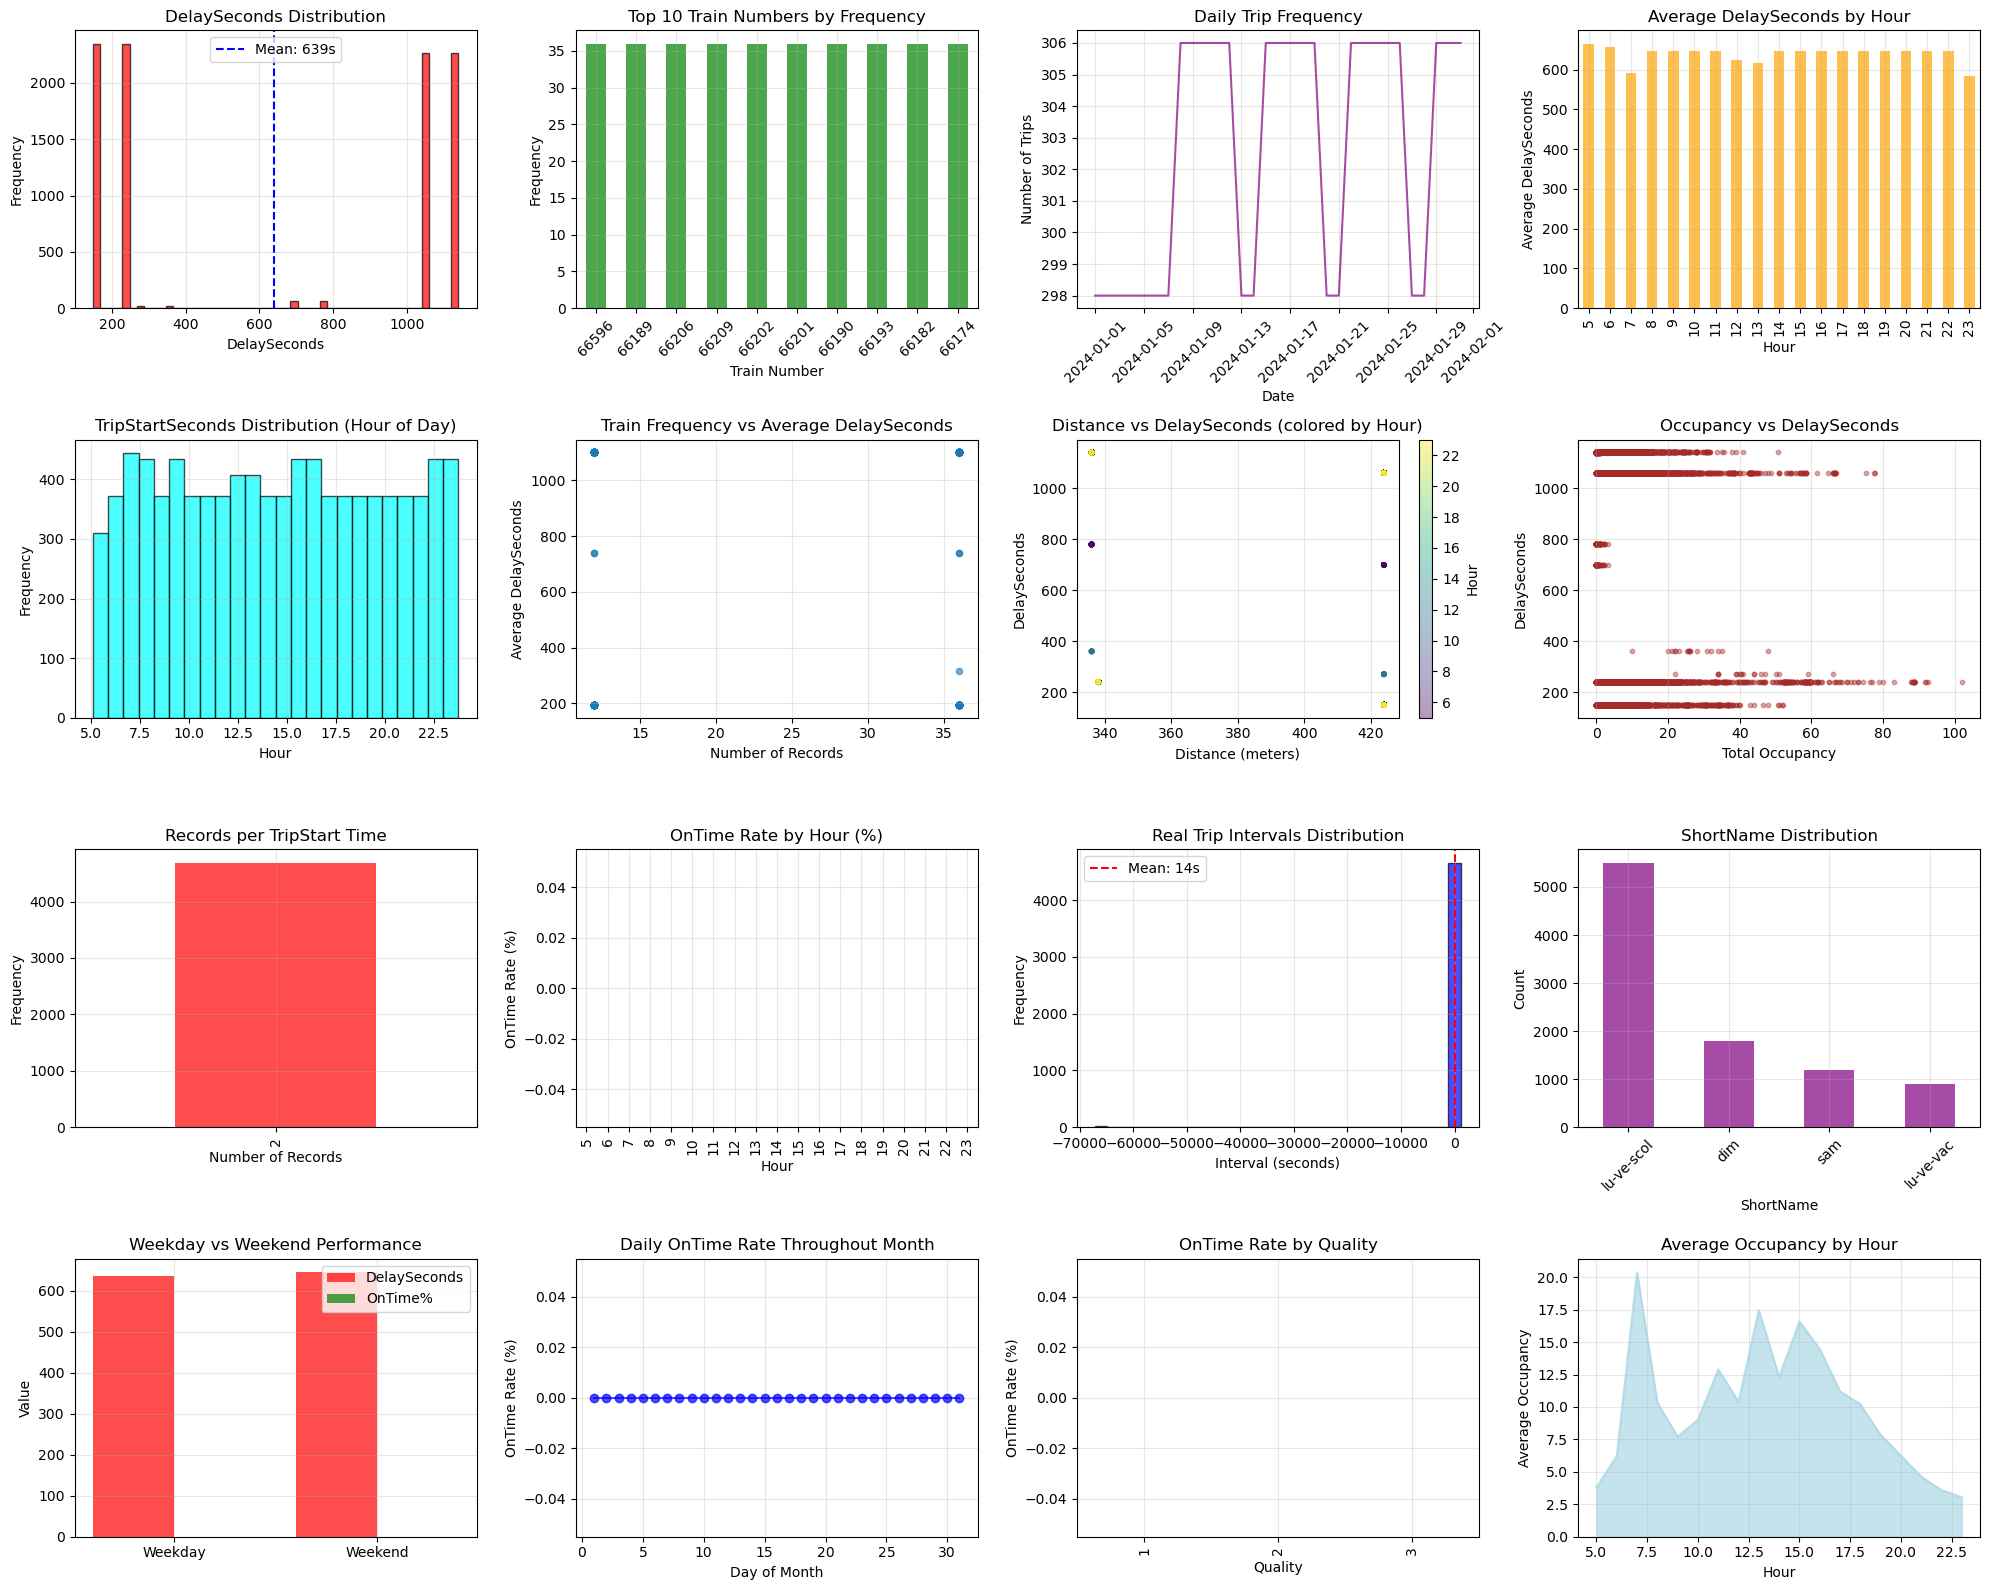


=== 关键发现 ===

📊 基本统计:
  DelaySeconds均值: 639.2秒 (10.7分钟)
  DelaySeconds中位数: 240.0秒
  总体准点率: 0.0%

🚌 车次分析:
  不同车次数: 600
  最频繁车次: 66001 (出现36次)

⏰ 时间模式:
  准点率最高时段: 5点 (0.0%)
  准点率最低时段: 5点 (0.0%)

🔍 数据质量:
  重复时间记录: 4691条 (50.0%)

📈 真实班次间隔:
  平均间隔: 14.3秒 (0.2分钟)
  间隔标准差: 5393.1秒
  最短间隔: -67079秒
  最长间隔: 1139秒

🎯 服务模式:
  ❌ 准点率需要改善
  ⚠️ 班次间隔变化较大


In [16]:
print("=== Plo站6号线深度分析 ===")
print(f"数据概况: {len(plo_line6_data)} 条记录，时间跨度: {plo_line6_data['Date'].min()} 到 {plo_line6_data['Date'].max()}")

plt.figure(figsize=(20, 16))

# 1. DelaySeconds分析 - 这个字段很关键
plt.subplot(4, 4, 1)
plt.hist(plo_line6_data['DelaySeconds'], bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title('DelaySeconds Distribution')
plt.xlabel('DelaySeconds')
plt.ylabel('Frequency')
plt.axvline(plo_line6_data['DelaySeconds'].mean(), color='blue', linestyle='--', 
            label=f'Mean: {plo_line6_data["DelaySeconds"].mean():.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. 同一车次(TrainNumber)的模式分析
plt.subplot(4, 4, 2)
train_counts = plo_line6_data['TrainNumber'].value_counts().head(10)
train_counts.plot(kind='bar', alpha=0.7, color='green')
plt.title('Top 10 Train Numbers by Frequency')
plt.xlabel('Train Number')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 3. 按日期的班次分布
plt.subplot(4, 4, 3)
daily_trips = plo_line6_data.groupby(plo_line6_data['Date'].dt.date).size()
daily_trips.plot(kind='line', alpha=0.7, color='purple')
plt.title('Daily Trip Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 4. DelaySeconds vs Hour 热力图
plt.subplot(4, 4, 4)
delay_by_hour = plo_line6_data.groupby('Hour')['DelaySeconds'].mean()
delay_by_hour.plot(kind='bar', alpha=0.7, color='orange')
plt.title('Average DelaySeconds by Hour')
plt.xlabel('Hour')
plt.ylabel('Average DelaySeconds')
plt.grid(True, alpha=0.3)

# 5. 分析TripStartSeconds的规律
plt.subplot(4, 4, 5)
# 看TripStartSeconds在一天中的分布
trip_start_hour = (plo_line6_data['TripStartSeconds'] % 86400) / 3600  # 转换为小时
plt.hist(trip_start_hour, bins=24, alpha=0.7, color='cyan', edgecolor='black')
plt.title('TripStartSeconds Distribution (Hour of Day)')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 6. 每个车次的平均DelaySeconds
plt.subplot(4, 4, 6)
train_delay = plo_line6_data.groupby('TrainNumber')['DelaySeconds'].agg(['mean', 'count'])
train_delay = train_delay[train_delay['count'] >= 10]  # 至少10次记录
plt.scatter(train_delay['count'], train_delay['mean'], alpha=0.6, s=20)
plt.title('Train Frequency vs Average DelaySeconds')
plt.xlabel('Number of Records')
plt.ylabel('Average DelaySeconds')
plt.grid(True, alpha=0.3)

# 7. 距离vs DelaySeconds关系
plt.subplot(4, 4, 7)
plt.scatter(plo_line6_data['DistanceMeters'], plo_line6_data['DelaySeconds'], 
           alpha=0.4, s=10, c=plo_line6_data['Hour'], cmap='viridis')
plt.colorbar(label='Hour')
plt.title('Distance vs DelaySeconds (colored by Hour)')
plt.xlabel('Distance (meters)')
plt.ylabel('DelaySeconds')
plt.grid(True, alpha=0.3)

# 8. 乘客占用率vs DelaySeconds
plt.subplot(4, 4, 8)
plt.scatter(plo_line6_data['TotalOccupancy'], plo_line6_data['DelaySeconds'], 
           alpha=0.4, s=10, color='brown')
plt.title('Occupancy vs DelaySeconds')
plt.xlabel('Total Occupancy')
plt.ylabel('DelaySeconds')
plt.grid(True, alpha=0.3)

# 9. 同一时间多个记录的分析
plt.subplot(4, 4, 9)
time_duplicates = plo_line6_data.groupby('TripStart').size()
duplicate_counts = time_duplicates.value_counts()
duplicate_counts.plot(kind='bar', alpha=0.7, color='red')
plt.title('Records per TripStart Time')
plt.xlabel('Number of Records')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 10. OnTime字段分析
plt.subplot(4, 4, 10)
ontime_by_hour = plo_line6_data.groupby('Hour')['OnTime'].mean() * 100
ontime_by_hour.plot(kind='bar', alpha=0.7, color='green')
plt.title('OnTime Rate by Hour (%)')
plt.xlabel('Hour')
plt.ylabel('OnTime Rate (%)')
plt.grid(True, alpha=0.3)

# 11. 计算真实的班次间隔
plt.subplot(4, 4, 11)
# 按TripStart时间排序，计算真实间隔
sorted_data = plo_line6_data.sort_values('TripStart')
unique_trips = sorted_data.drop_duplicates(subset=['TripStart'])  # 去除重复时间
real_intervals = np.diff(unique_trips['TripStartSeconds'])
plt.hist(real_intervals, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Real Trip Intervals Distribution')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.axvline(np.mean(real_intervals), color='red', linestyle='--', 
            label=f'Mean: {np.mean(real_intervals):.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 12. ShortName模式分析
plt.subplot(4, 4, 12)
shortname_counts = plo_line6_data['ShortName'].value_counts()
shortname_counts.plot(kind='bar', alpha=0.7, color='purple')
plt.title('ShortName Distribution')
plt.xlabel('ShortName')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 13. 工作日vs周末分析
plt.subplot(4, 4, 13)
plo_line6_data['Weekday'] = plo_line6_data['Date'].dt.day_name()
plo_line6_data['IsWeekend'] = plo_line6_data['Date'].dt.weekday >= 5
weekend_analysis = plo_line6_data.groupby('IsWeekend').agg({
    'DelaySeconds': 'mean',
    'OnTime': 'mean',
    'TotalOccupancy': 'mean'
})
weekend_analysis['OnTime'] *= 100

x = [0, 1]
plt.bar([x[0]-0.2, x[1]-0.2], weekend_analysis['DelaySeconds'], width=0.4, 
        label='DelaySeconds', alpha=0.7, color='red')
plt.bar([x[0]+0.2, x[1]+0.2], weekend_analysis['OnTime'], width=0.4, 
        label='OnTime%', alpha=0.7, color='green')
plt.xticks(x, ['Weekday', 'Weekend'])
plt.title('Weekday vs Weekend Performance')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)

# 14. 月度趋势
plt.subplot(4, 4, 14)
plo_line6_data['Day'] = plo_line6_data['Date'].dt.day
daily_ontime = plo_line6_data.groupby('Day')['OnTime'].mean() * 100
daily_ontime.plot(kind='line', alpha=0.7, color='blue', marker='o')
plt.title('Daily OnTime Rate Throughout Month')
plt.xlabel('Day of Month')
plt.ylabel('OnTime Rate (%)')
plt.grid(True, alpha=0.3)

# 15. Quality字段分析
plt.subplot(4, 4, 15)
quality_ontime = plo_line6_data.groupby('Quality')['OnTime'].mean() * 100
quality_ontime.plot(kind='bar', alpha=0.7, color='orange')
plt.title('OnTime Rate by Quality')
plt.xlabel('Quality')
plt.ylabel('OnTime Rate (%)')
plt.grid(True, alpha=0.3)

# 16. 时间序列趋势
plt.subplot(4, 4, 16)
# 每小时平均乘客数
hourly_passengers = plo_line6_data.groupby('Hour')['TotalOccupancy'].mean()
hourly_passengers.plot(kind='area', alpha=0.7, color='lightblue')
plt.title('Average Occupancy by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Occupancy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 详细统计分析
print("\n=== 关键发现 ===")

print(f"\n📊 基本统计:")
print(f"  DelaySeconds均值: {plo_line6_data['DelaySeconds'].mean():.1f}秒 ({plo_line6_data['DelaySeconds'].mean()/60:.1f}分钟)")
print(f"  DelaySeconds中位数: {plo_line6_data['DelaySeconds'].median():.1f}秒")
print(f"  总体准点率: {plo_line6_data['OnTime'].mean()*100:.1f}%")

print(f"\n🚌 车次分析:")
print(f"  不同车次数: {plo_line6_data['TrainNumber'].nunique()}")
print(f"  最频繁车次: {plo_line6_data['TrainNumber'].mode().iloc[0]} (出现{plo_line6_data['TrainNumber'].value_counts().iloc[0]}次)")

print(f"\n⏰ 时间模式:")
best_hour = ontime_by_hour.idxmax()
worst_hour = ontime_by_hour.idxmin()
print(f"  准点率最高时段: {best_hour}点 ({ontime_by_hour[best_hour]:.1f}%)")
print(f"  准点率最低时段: {worst_hour}点 ({ontime_by_hour[worst_hour]:.1f}%)")

print(f"\n🔍 数据质量:")
duplicate_times = len(plo_line6_data) - len(plo_line6_data['TripStart'].unique())
print(f"  重复时间记录: {duplicate_times}条 ({duplicate_times/len(plo_line6_data)*100:.1f}%)")

print(f"\n📈 真实班次间隔:")
print(f"  平均间隔: {np.mean(real_intervals):.1f}秒 ({np.mean(real_intervals)/60:.1f}分钟)")
print(f"  间隔标准差: {np.std(real_intervals):.1f}秒")
print(f"  最短间隔: {np.min(real_intervals):.0f}秒")
print(f"  最长间隔: {np.max(real_intervals):.0f}秒")

print(f"\n🎯 服务模式:")
if plo_line6_data['OnTime'].mean() > 0.8:
    print("  ✅ 整体准点率良好")
elif plo_line6_data['OnTime'].mean() > 0.6:
    print("  ⚠️ 准点率中等")
else:
    print("  ❌ 准点率需要改善")

if np.std(real_intervals)/np.mean(real_intervals) < 0.5:
    print("  ✅ 班次间隔相对规律")
else:
    print("  ⚠️ 班次间隔变化较大")